In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [54]:
loan_data =pd.read_csv('loan.csv')

/var/folders/0q/clpdbrcs35q427c4ncjr3ttc0000gn/T/ipykernel_62492/3432352245.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data =pd.read_csv('loan.csv')


In [55]:
print(loan_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB
None


# Handling Missing Values and data cleaning

In [56]:
loan_data['term']

0         36 months
1         60 months
2         36 months
3         36 months
4         60 months
            ...    
39712     36 months
39713     36 months
39714     36 months
39715     36 months
39716     36 months
Name: term, Length: 39717, dtype: object

In [57]:
loan_data['term'] = loan_data['term'].str.extract('(\d+)').astype('float')

In [58]:
loan_data['term']

0        36.0
1        60.0
2        36.0
3        36.0
4        60.0
         ... 
39712    36.0
39713    36.0
39714    36.0
39715    36.0
39716    36.0
Name: term, Length: 39717, dtype: float64

In [59]:
loan_data['annual_inc'] = loan_data['annual_inc'].fillna(loan_data['annual_inc'].median())
loan_data['loan_amnt'] = loan_data['loan_amnt'].fillna(loan_data['loan_amnt'].median())
loan_data['int_rate'] = loan_data['int_rate'].str.rstrip('%').astype('float')  # Converting to float
loan_data['int_rate'] = loan_data['int_rate'].fillna(loan_data['int_rate'].median())
loan_data['grade'] = loan_data['grade'].fillna("Unkown")
loan_data['term'] = loan_data['term'].fillna("Unkown")
loan_data['dti'] = loan_data['dti'].fillna(loan_data['dti'].median())
loan_data['emp_length'] = loan_data['emp_length'].fillna('Unknown')

In [60]:
# This step is crucial as outliers can significantly affect the analysis
#I have usen this is because i thing creating a regression modele here is beter
cap_percentile = 95
cap_value = loan_data['annual_inc'].quantile(cap_percentile / 100)
loan_data['annual_inc'] = np.where(loan_data['annual_inc'] > cap_value, cap_value, loan_data['annual_inc'])

In [61]:
# Example: Dropping columns with a high percentage of missing values
threshold = 0.5  # Threshold for dropping columns, e.g., 50% missing values
loan_data = loan_data.dropna(thresh=int(threshold * len(loan_data)), axis=1)

In [62]:
# Normalize your chosen variables (example: DTI, loan_amnt)
loan_data['normalized_dti'] = (loan_data['dti'] - loan_data['dti'].min()) / (loan_data['dti'].max() - loan_data['dti'].min())
loan_data['normalized_loan_amnt'] = (loan_data['loan_amnt'] - loan_data['loan_amnt'].min()) / (loan_data['loan_amnt'].max() - loan_data['loan_amnt'].min())

In [63]:
loan_data['credit_score'] = 100 - (loan_data['normalized_dti'] * 0.7 + loan_data['normalized_loan_amnt'] * 0.3) * 100

In [64]:
print(loan_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  float64
 6   int_rate                    39717 non-null  float64
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  39717 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [65]:
loan_data.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  term  \
0  1077501    1296599       5000         5000           4975.0  36.0   
1  1077430    1314167       2500         2500           2500.0  60.0   
2  1077175    1313524       2400         2400           2400.0  36.0   
3  1076863    1277178      10000        10000          10000.0  36.0   
4  1075358    1311748       3000         3000           3000.0  60.0   

   int_rate  installment grade sub_grade  ... policy_code application_type  \
0     10.65       162.87     B        B2  ...           1       INDIVIDUAL   
1     15.27        59.83     C        C4  ...           1       INDIVIDUAL   
2     15.96        84.33     C        C5  ...           1       INDIVIDUAL   
3     13.49       339.31     C        C1  ...           1       INDIVIDUAL   
4     12.69        67.79     B        B5  ...           1       INDIVIDUAL   

  acc_now_delinq  chargeoff_within_12_mths delinq_amnt pub_rec_bankruptcies  \
0              0                       0.0           0                  0.0   
1              0                       0.0           0                  0.0   
2              0                       0.0           0                  0.0   
3              0                       0.0           0                  0.0   
4              0                       0.0           0                  0.0   

  tax_liens normalized_dti normalized_loan_amnt credit_score  
0       0.0       0.921974             0.130435    31.548777  
1       0.0       0.033344             0.057971    95.926758  
2       0.0       0.290764             0.055072    77.994375  
3       0.0       0.666889             0.275362    45.056903  
4       0.0       0.598199             0.072464    55.952129  

[5 rows x 57 columns]

# creating derived colunms

In [66]:
loan_data['loan_utilization_rate'] = loan_data['funded_amnt'] / loan_data['loan_amnt']
loan_data['int_rate_decimal'] = loan_data['int_rate'] / 100 # 'int_rate' is in percentage format, converting it to a decimal for easier calculations
loan_data['term_years'] = loan_data['term'] / 12
loan_data['loan_to_income'] = loan_data['loan_amnt'] / loan_data['annual_inc']
loan_data['monthly_income'] = loan_data['annual_inc'] / 12
loan_data['pti'] = loan_data['installment'] / loan_data['monthly_income'] #The ratio of the monthly loan payment ('installment') to the monthly income.

In [67]:
def categorize_interest_rate(rate):
    if rate < 5:
        return '0-5%'
    elif rate < 10:
        return '5-10%'
    elif rate < 15:
        return '10-15%'
    elif rate < 20:
        return '15-20%'
    elif rate < 25:
        return '20-25%'
    else:
        return '25%+'

loan_data['int_rate_category'] = loan_data['int_rate'].apply(categorize_interest_rate)

In [68]:
def categorize_credit_score(score):
    if score <= 20:
        return '0-20'
    elif score <= 40:
        return '21-40'
    elif score <= 60:
        return '41-60'
    elif score <= 80:
        return '61-80'
    else:
        return '81-100'
loan_data['credit_score_category'] = loan_data['credit_score'].apply(categorize_credit_score)
loan_data['is_default'] = loan_data['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

# Univariate

In [69]:
loan_data['earliest_cr_line'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y')
loan_data['earliest_cr_line'] = loan_data['earliest_cr_line'].apply(lambda x: x if x.year <= 2022 else x.replace(year=x.year-100))

In [70]:
loan_data['year'] = loan_data['earliest_cr_line'].dt.year
loan_data['month'] = loan_data['earliest_cr_line'].dt.month


In [71]:
loan_data['year_month'] = loan_data['year'].astype(str) + '-' + loan_data['month'].astype(str)

In [72]:
grouped_data1 = loan_data.groupby('year')['int_rate'].mean().reset_index()

In [73]:
grouped_data = loan_data.groupby('year')['loan_amnt'].mean().reset_index()


grouped_data2 = loan_data.groupby('year')['credit_score'].mean().reset_index()

grouped_data3 = loan_data.groupby('year')['dti'].mean().reset_index()
grouped_data4 = loan_data.groupby('year')['annual_inc'].mean().reset_index()

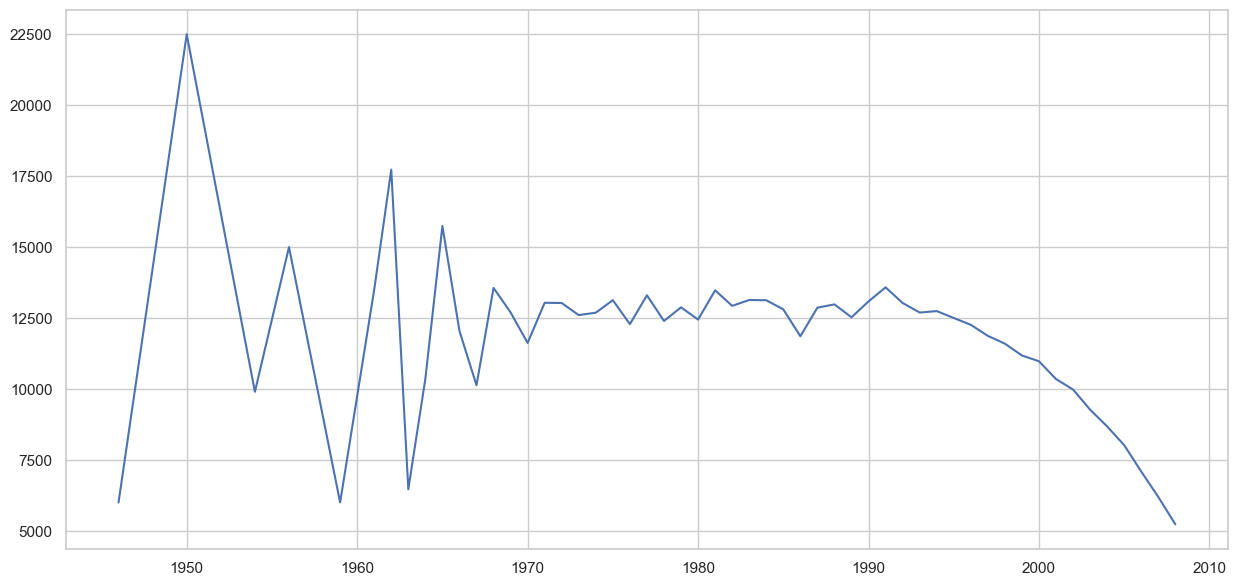

In [75]:
plt.figure(figsize=(15, 7))
plt.plot(grouped_data['year'], grouped_data['loan_amnt'], label='Average Loan Amount')

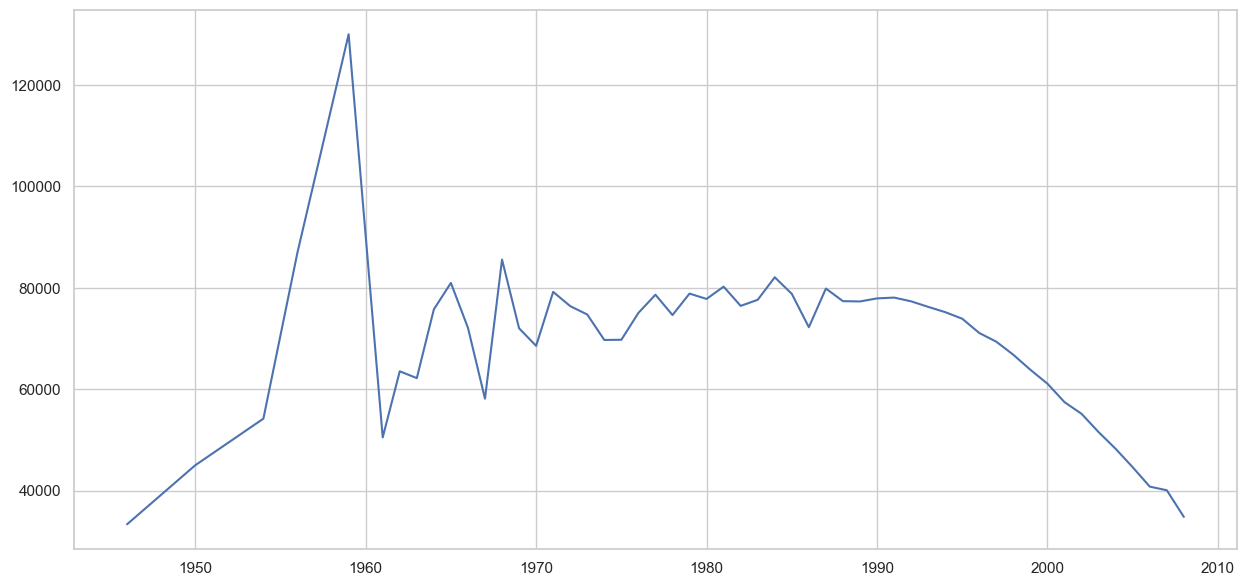

In [76]:
plt.figure(figsize=(15, 7))
plt.plot(grouped_data4['year'], grouped_data4['annual_inc'], label='Average income Amount')

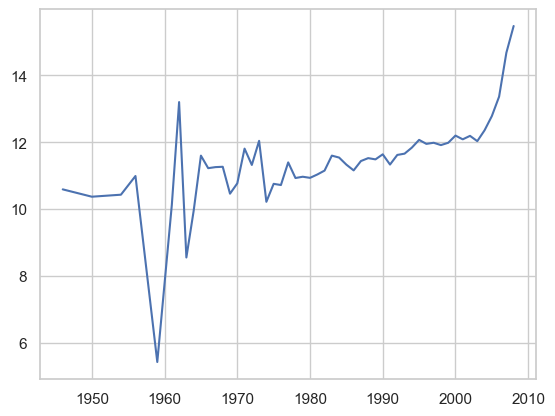

In [77]:
plt.plot(grouped_data1['year'], grouped_data1['int_rate'], label='Average intrest Amount')

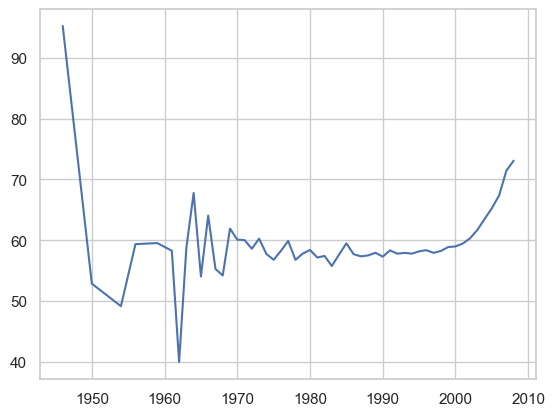

In [78]:
plt.plot(grouped_data2['year'], grouped_data2['credit_score'], label='Average credit score Amount')

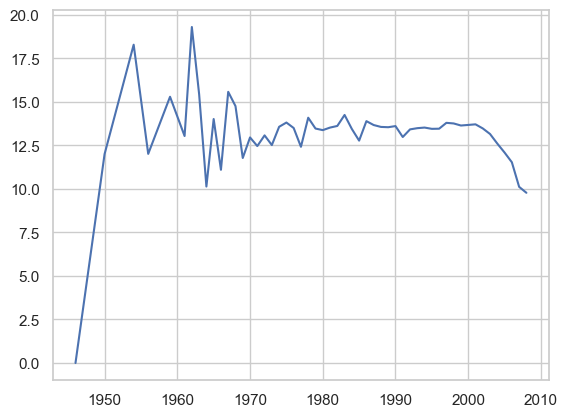

In [79]:
plt.plot(grouped_data3['year'], grouped_data3['dti'], label='average dti')

In [80]:
grouped_data_count = loan_data.groupby('year').count()

In [81]:
grouped_data_count

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  term  \
year                                                                   
1946     1          1          1            1                1     1   
1950     1          1          1            1                1     1   
1954     2          2          2            2                2     2   
1956     1          1          1            1                1     1   
1959     1          1          1            1                1     1   
1961     2          2          2            2                2     2   
1962     5          5          5            5                5     5   
1963    10         10         10           10               10    10   
1964     9          9          9            9                9     9   
1965     9          9          9            9                9     9   
1966    11         11         11           11               11    11   
1967    18         18         18           18               18    18   
1968    20         20         20           20               20    20   
1969    37         37         37           37               37    37   
1970    48         48         48           48               48    48   
1971    46         46         46           46               46    46   
1972    53         53         53           53               53    53   
1973    66         66         66           66               66    66   
1974    65         65         65           65               65    65   
1975    83         83         83           83               83    83   
1976    97         97         97           97               97    97   
1977   115        115        115          115              115   115   
1978   165        165        165          165              165   165   
1979   165        165        165          165              165   165   
1980   180        180        180          180              180   180   
1981   187        187        187          187              187   187   
1982   224        224        224          224              224   224   
1983   338        338        338          338              338   338   
1984   409        409        409          409              409   409   
1985   461        461        461          461              461   461   
1986   500        500        500          500              500   500   
1987   618        618        618          618              618   618   
1988   740        740        740          740              740   740   
1989   861        861        861          861              861   861   
1990  1038       1038       1038         1038             1038  1038   
1991   980        980        980          980              980   980   
1992  1063       1063       1063         1063             1063  1063   
1993  1514       1514       1514         1514             1514  1514   
1994  2027       2027       2027         2027             2027  2027   
1995  2150       2150       2150         2150             2150  2150   
1996  2274       2274       2274         2274             2274  2274   
1997  2456       2456       2456         2456             2456  2456   
1998  2851       2851       2851         2851             2851  2851   
1999  2968       2968       2968         2968             2968  2968   
2000  3250       3250       3250         3250             3250  3250   
2001  2521       2521       2521         2521             2521  2521   
2002  1927       1927       1927         1927             1927  1927   
2003  1856       1856       1856         1856             1856  1856   
2004  1761       1761       1761         1761             1761  1761   
2005  1493       1493       1493         1493             1493  1493   
2006  1169       1169       1169         1169             1169  1169   
2007   712        712        712          712              712   712   
2008   159        159        159          159              159   159   

      int_rate  installment  grade  sub_grade  

In [82]:
sns.set(style="whitegrid")

key_variables = ['loan_amnt', 'funded_amnt', 'int_rate', 'term', 'grade', 'annual_inc', 'dti','home_ownership','credit_score','is_default']

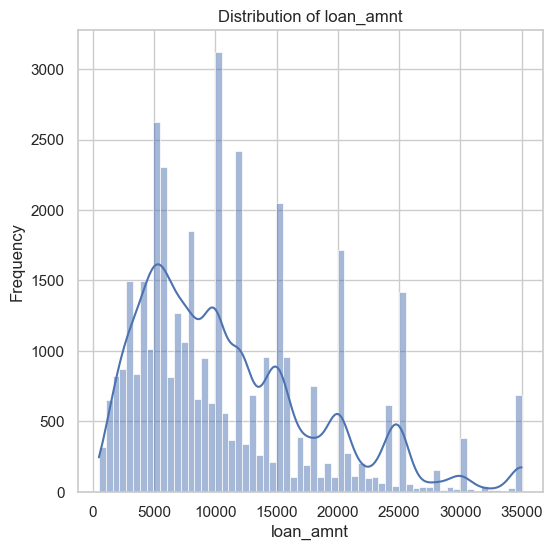

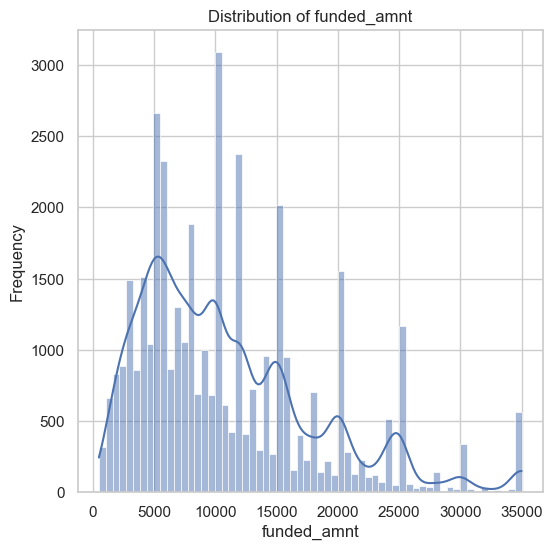

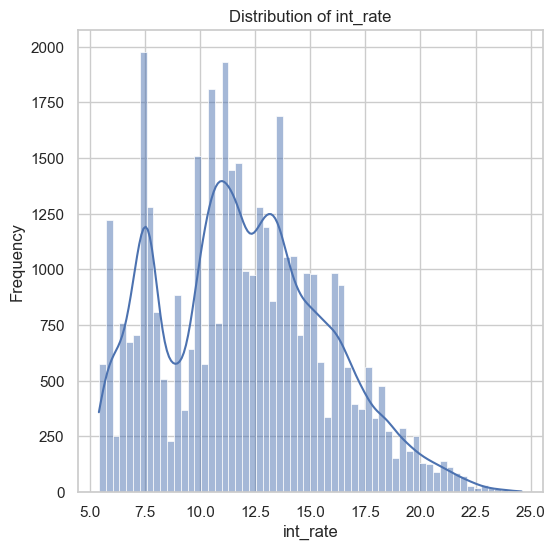

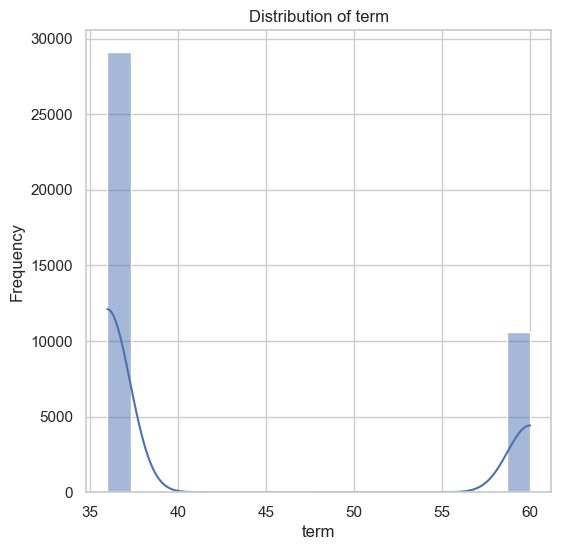

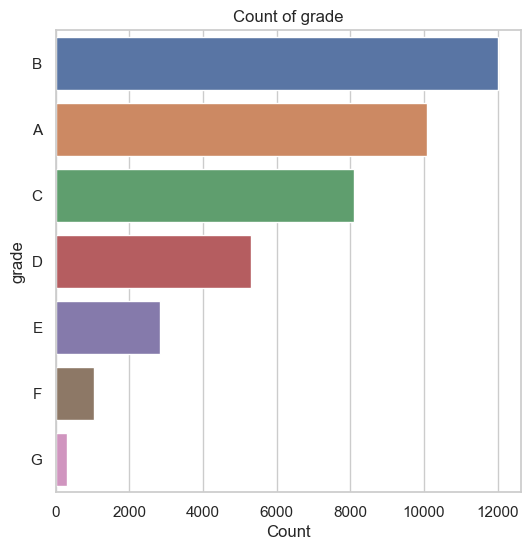

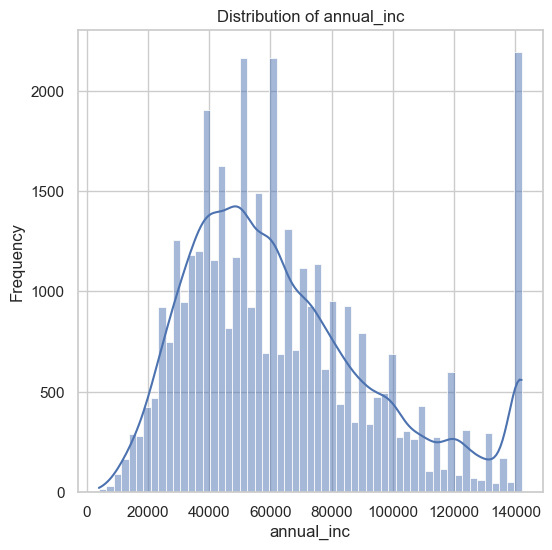

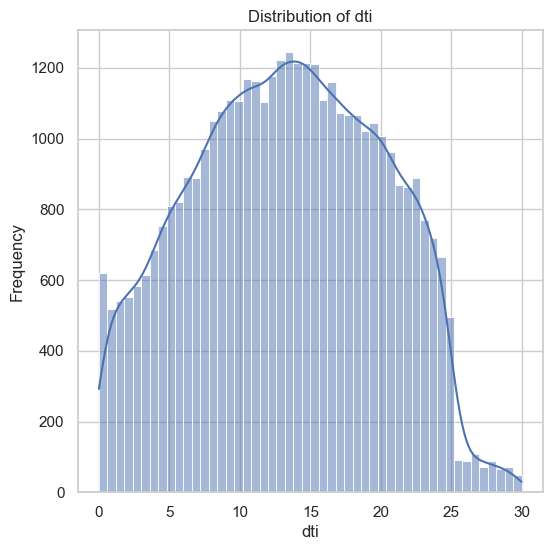

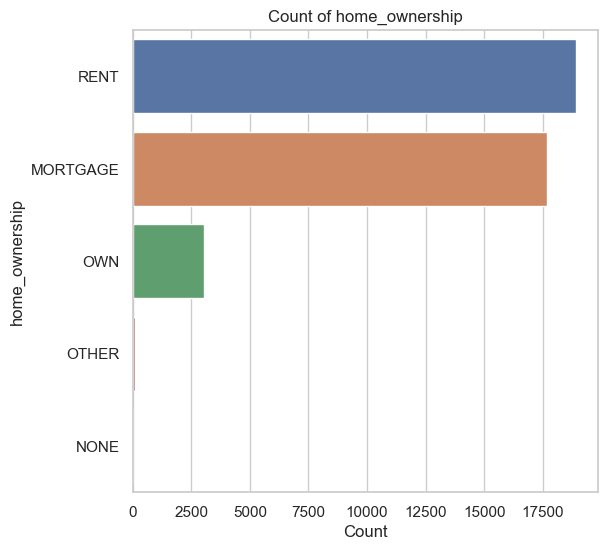

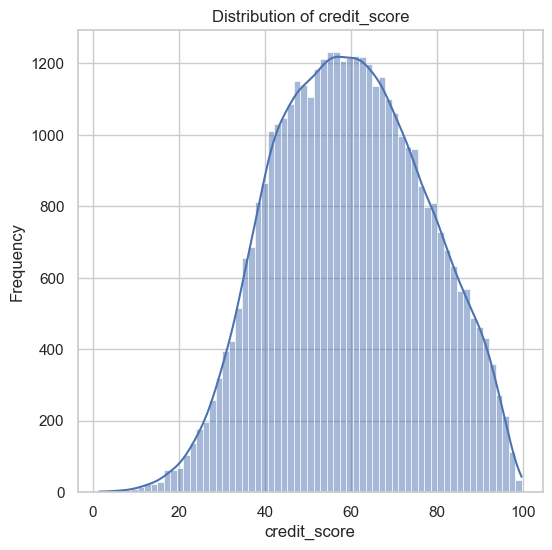

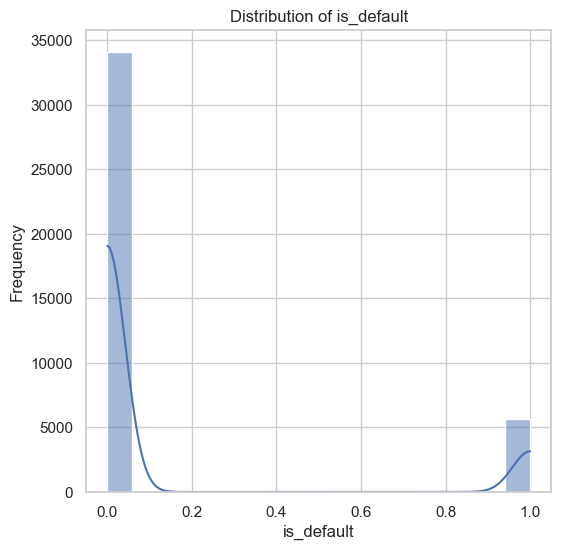

In [83]:
# Univariate Analysis of each variable
for variable in key_variables:
    plt.figure(figsize=(6, 6))

    if loan_data[variable].dtype == 'float64' or loan_data[variable].dtype == 'int64':
        # For numerical variables, use a histogram
        sns.histplot(loan_data[variable].dropna(), kde=True)
        plt.title(f'Distribution of {variable}')
        plt.xlabel(variable)
        plt.ylabel('Frequency')
    else:
        # For categorical variables, use a count plot
        sns.countplot(y=variable, data=loan_data, order = loan_data[variable].value_counts().index)
        plt.title(f'Count of {variable}')
        plt.xlabel('Count')
        plt.ylabel(variable)

    plt.show()

# Segmenting by 'Grade'

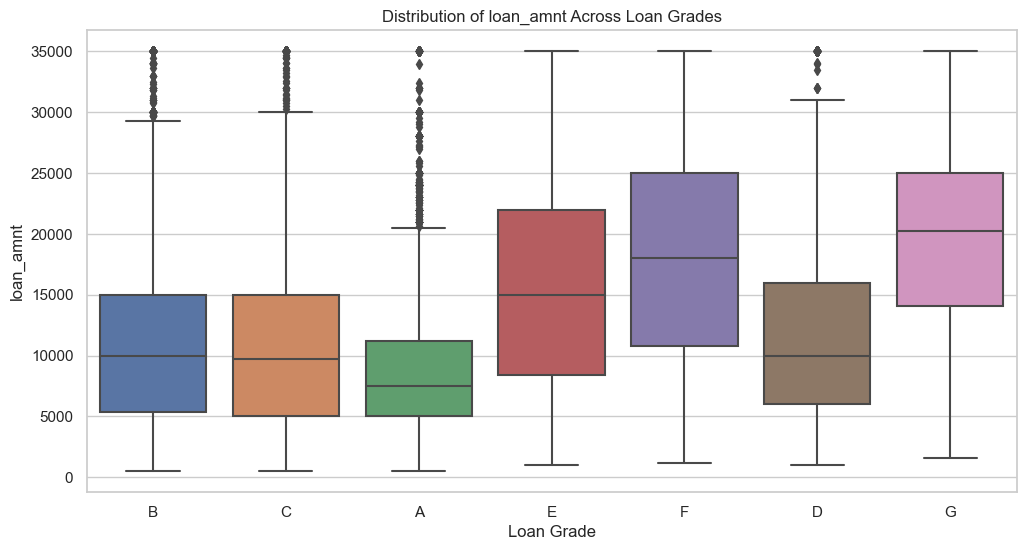

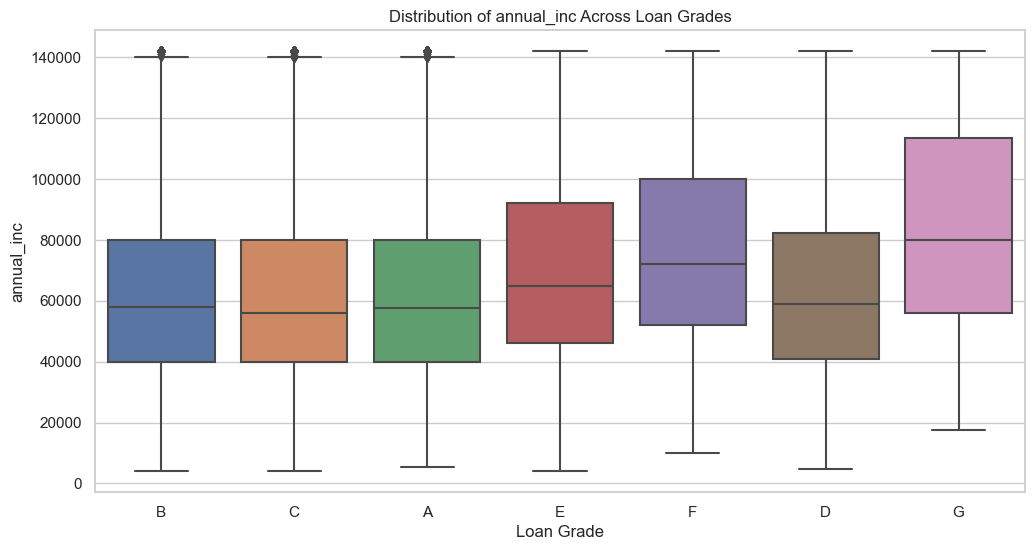

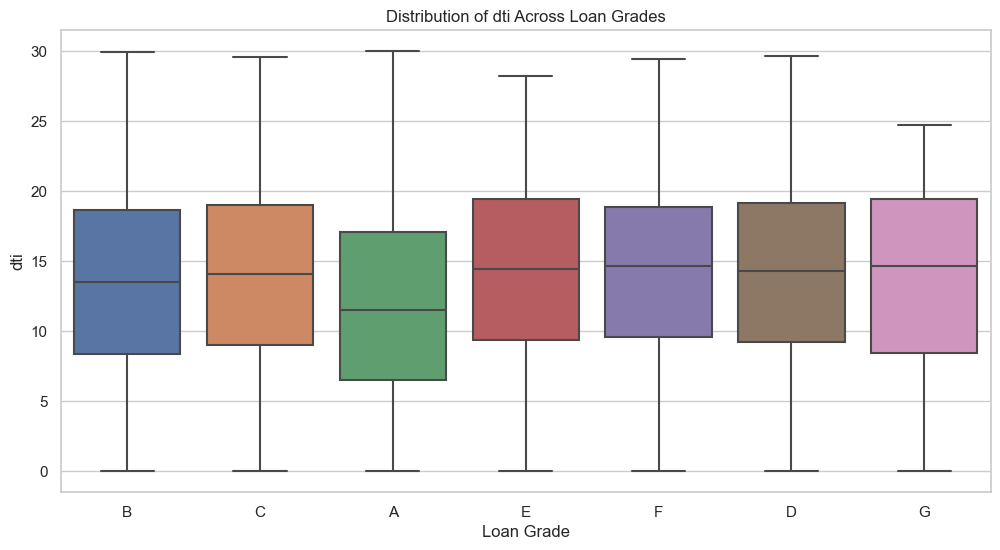

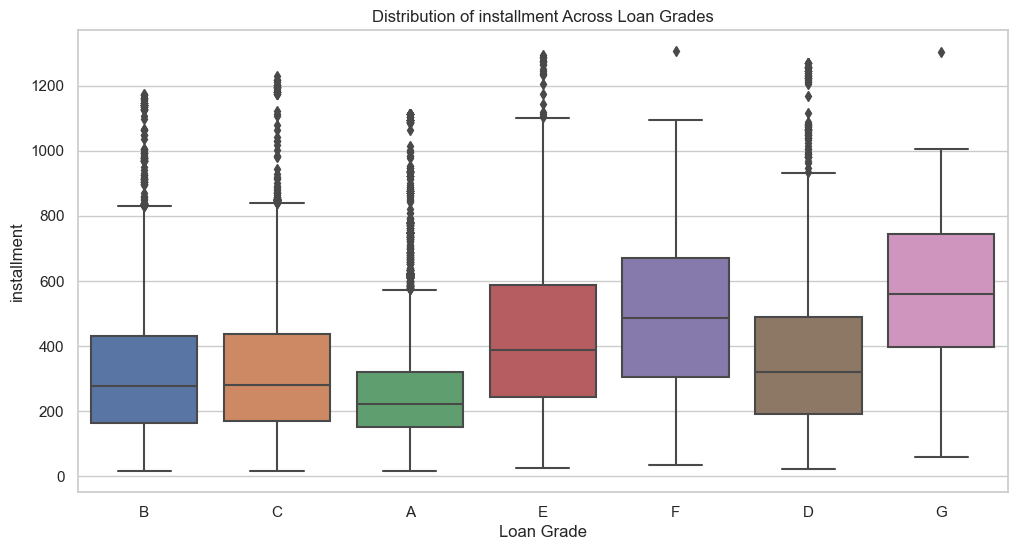

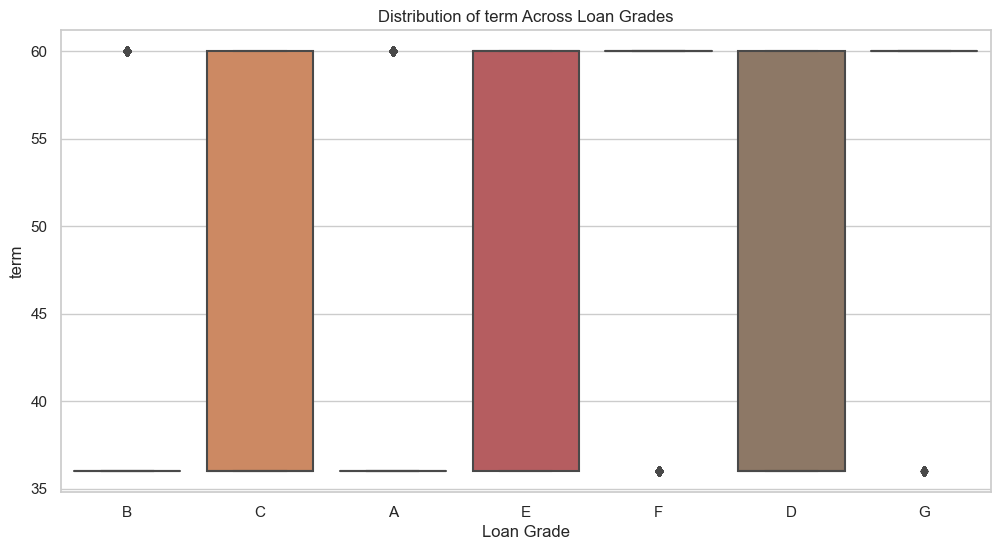

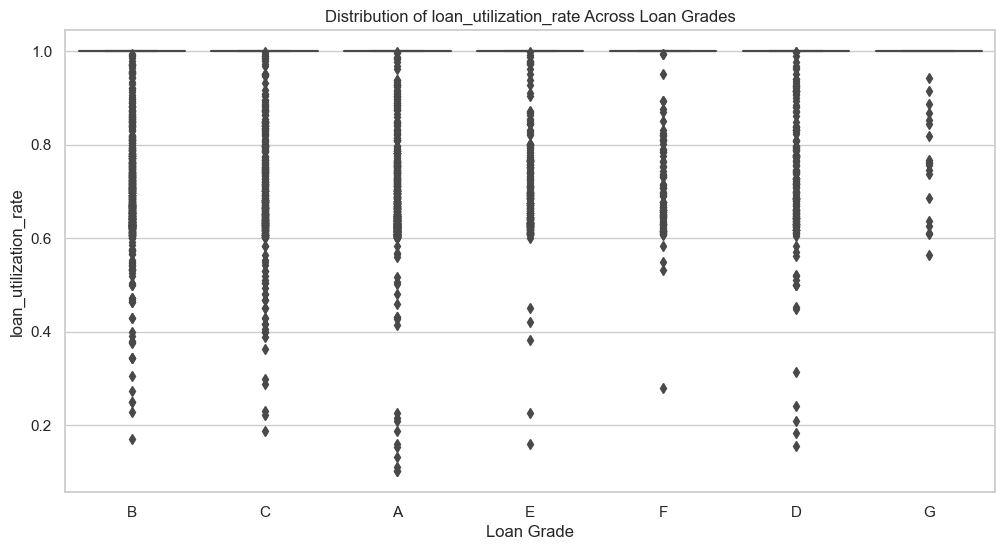

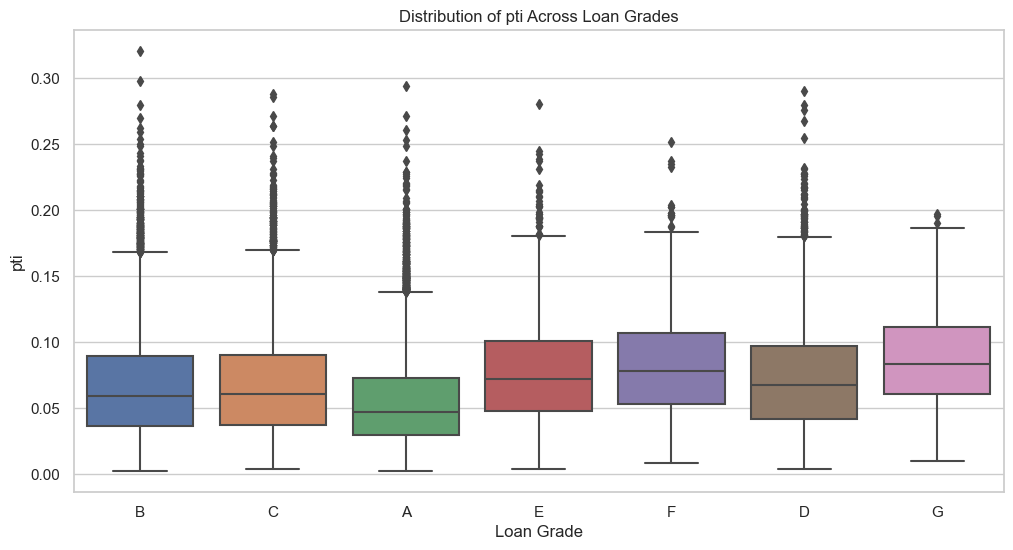

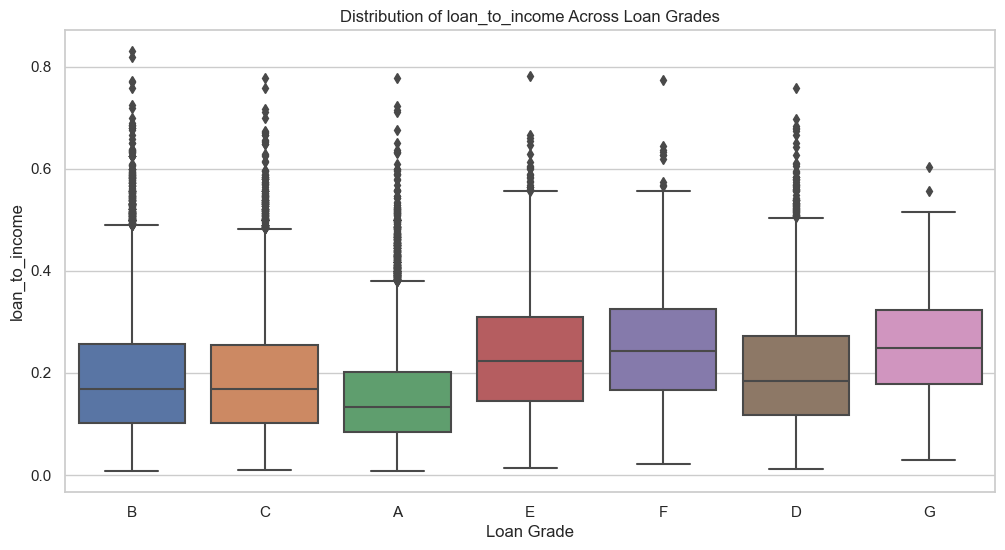

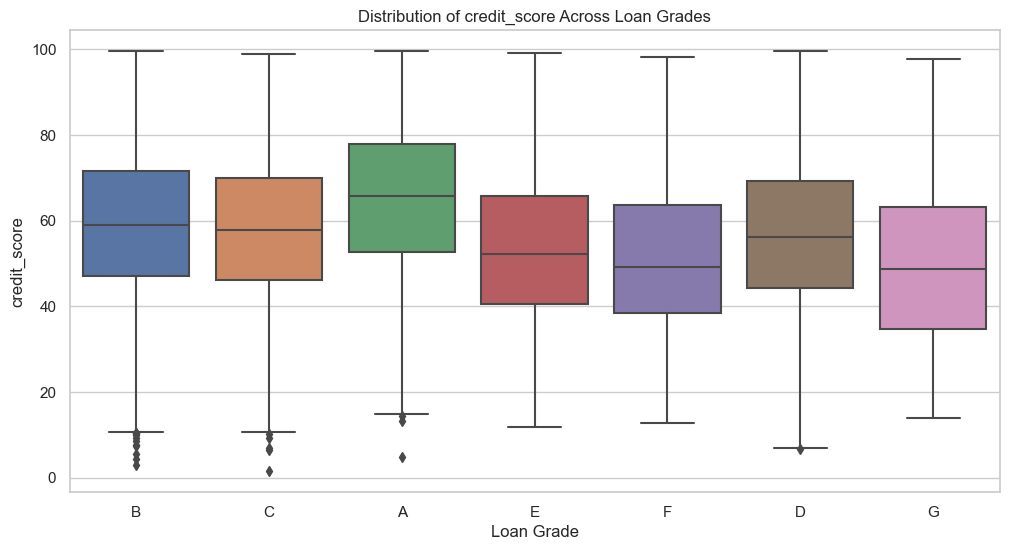

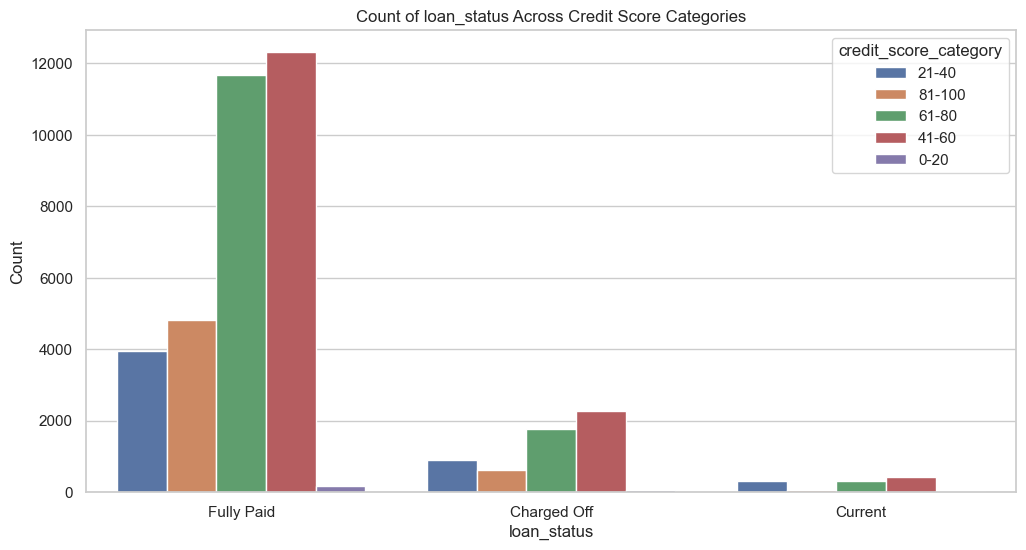

In [84]:
segment_variables = ['loan_amnt', 'annual_inc', 'dti', 'installment', 'term', 
                      'loan_utilization_rate', 'pti', 'loan_to_income','credit_score','loan_status']

# Plotting segmented analysis based on loan grade for various variables
for variable in segment_variables:
    plt.figure(figsize=(12, 6))

    # Use boxplot for numerical variables
    if loan_data[variable].dtype in ['float64', 'int64']:
        sns.boxplot(x='grade', y=variable, data=loan_data)
        plt.title(f'Distribution of {variable} Across Loan Grades')
        plt.xlabel('Loan Grade')
        plt.ylabel(variable)
    # Use count plot for categorical variables
    elif loan_data[variable].dtype == 'object':
        sns.countplot(x=variable, hue='credit_score_category', data=loan_data)
        plt.title(f'Count of {variable} Across Credit Score Categories')
        plt.xlabel(variable)
        plt.ylabel('Count')

    plt.show()

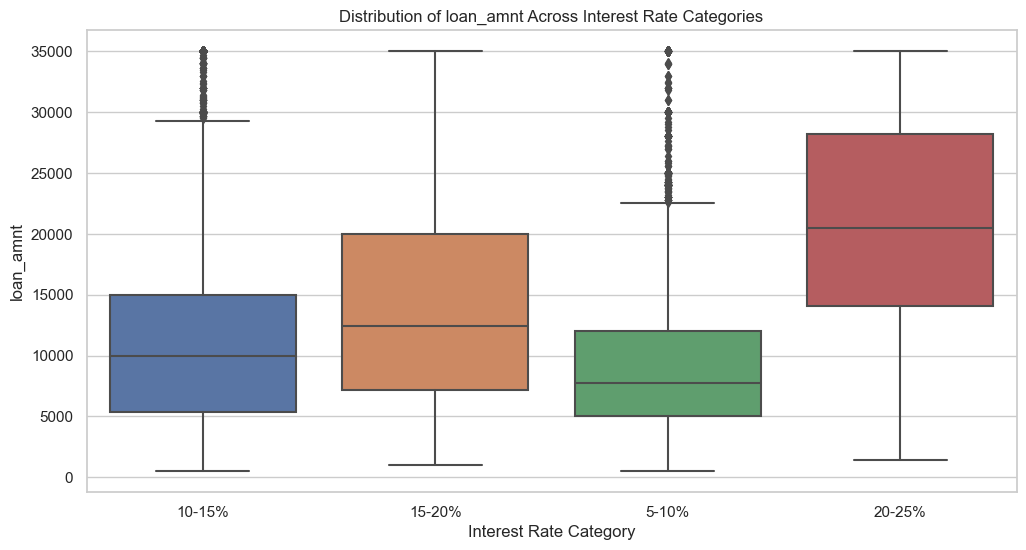

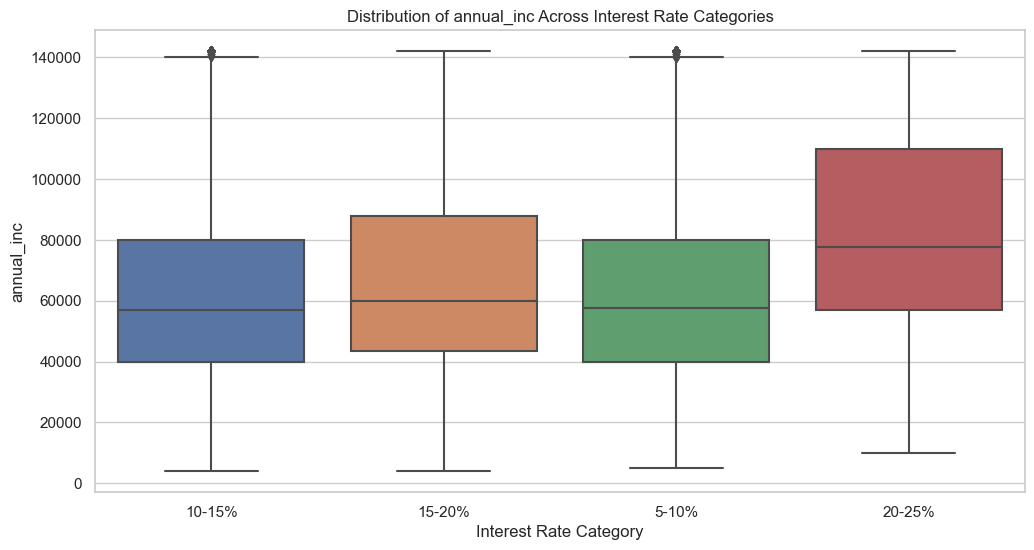

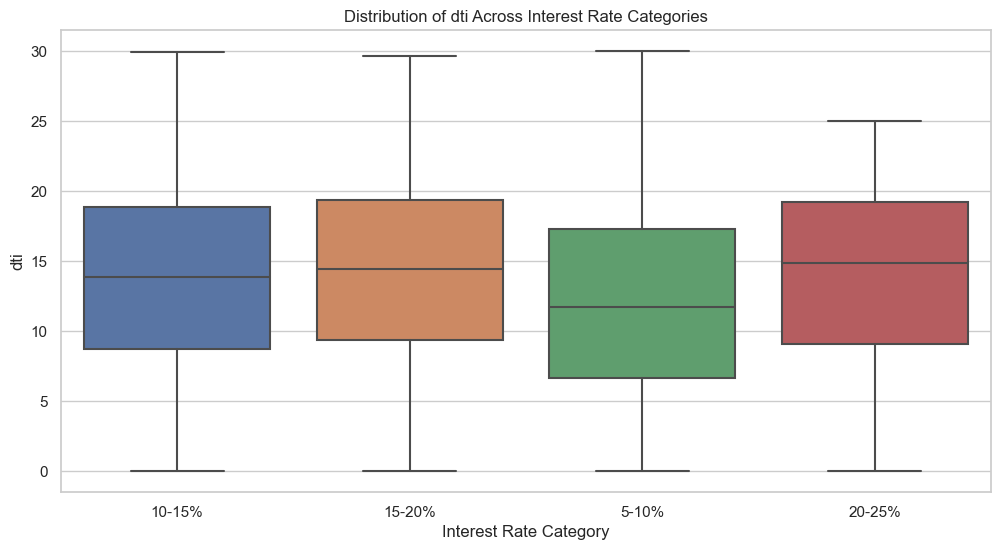

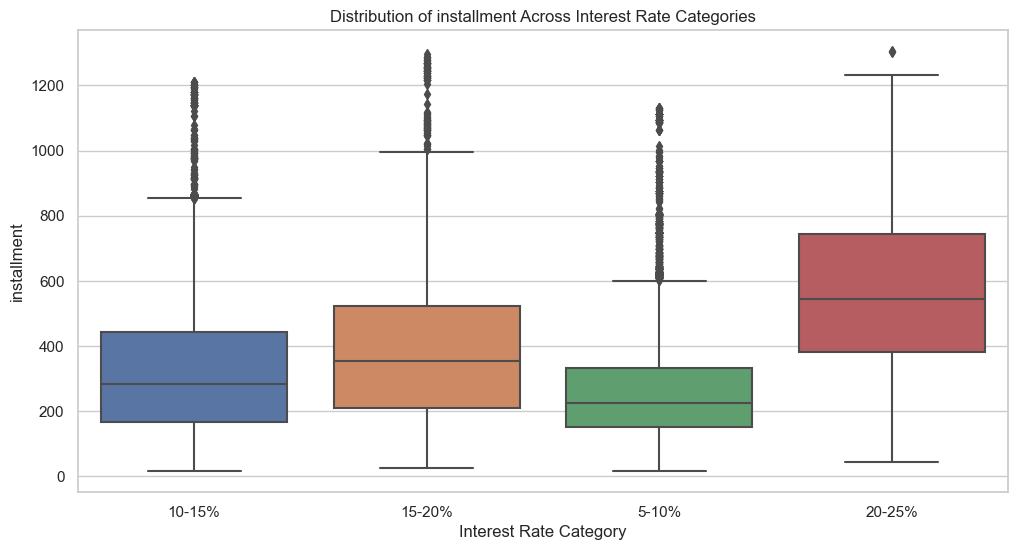

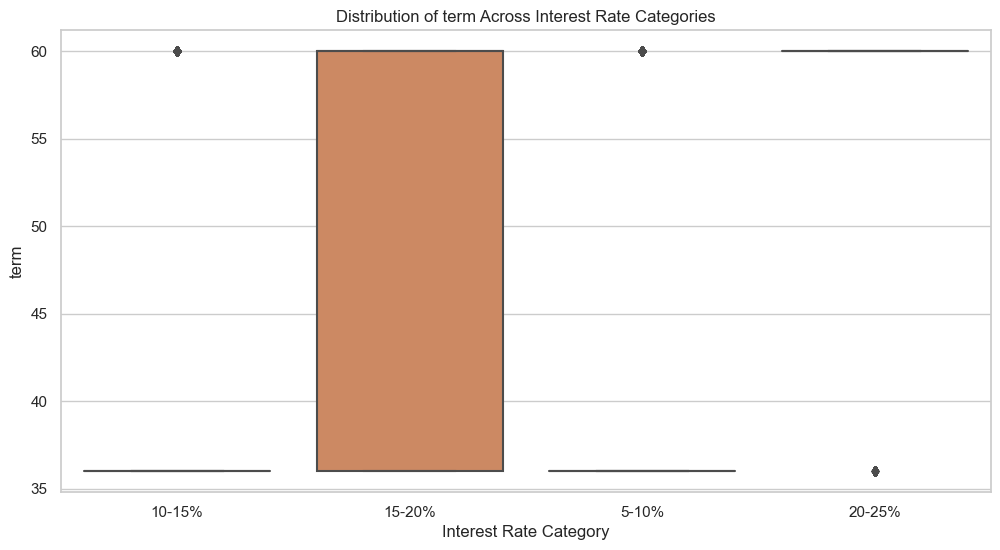

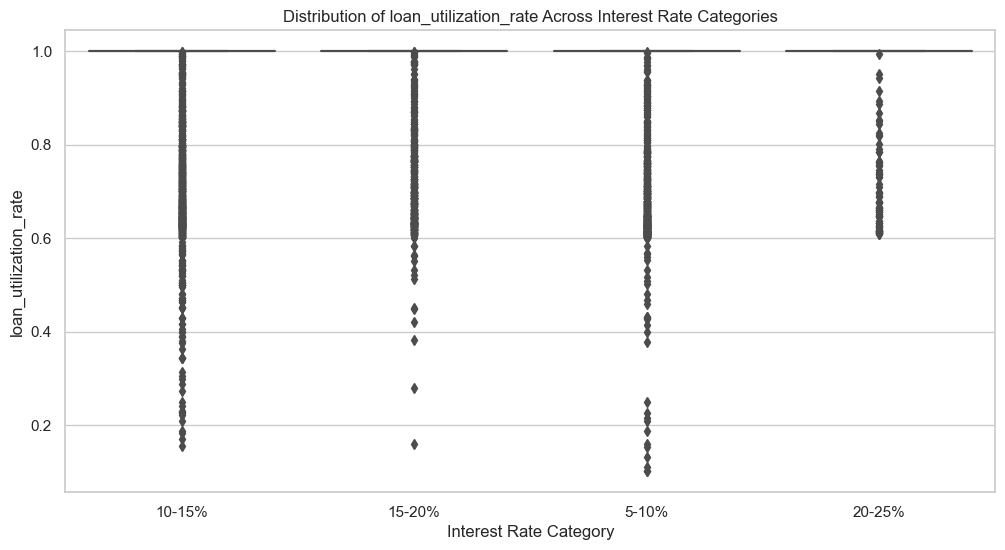

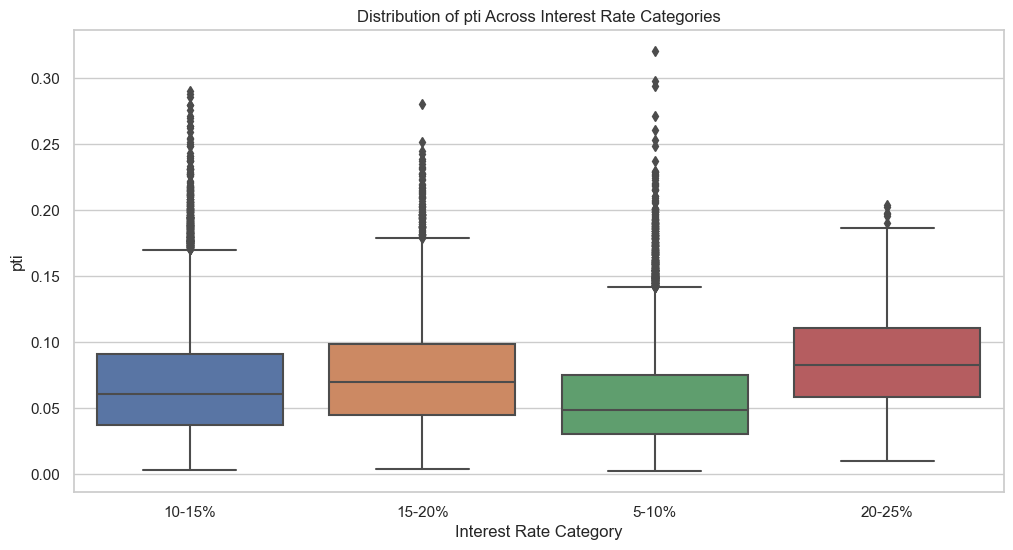

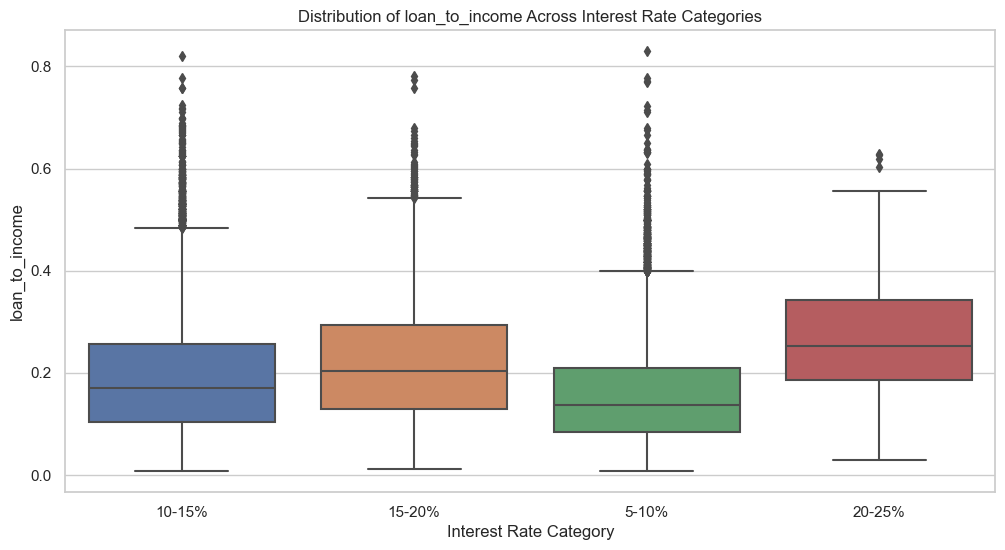

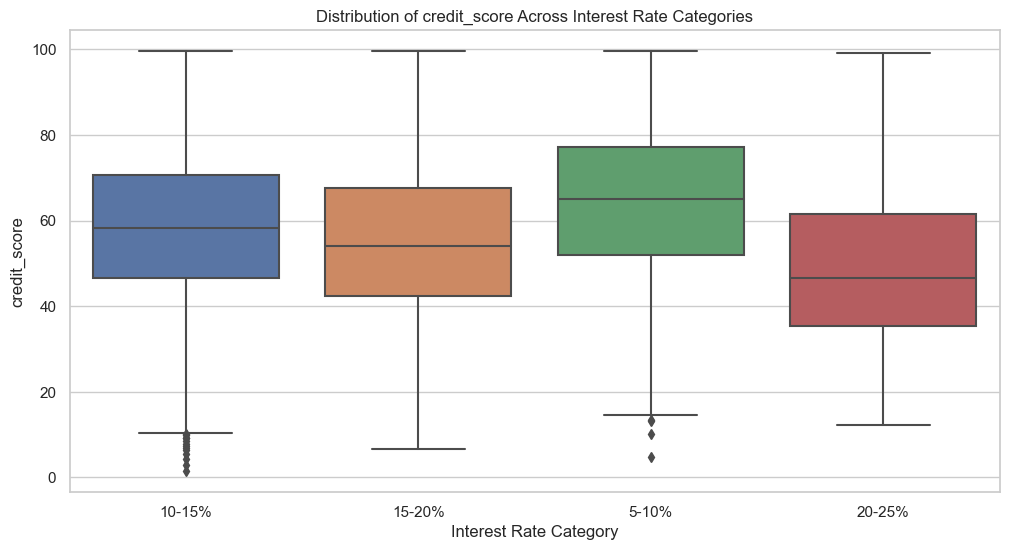

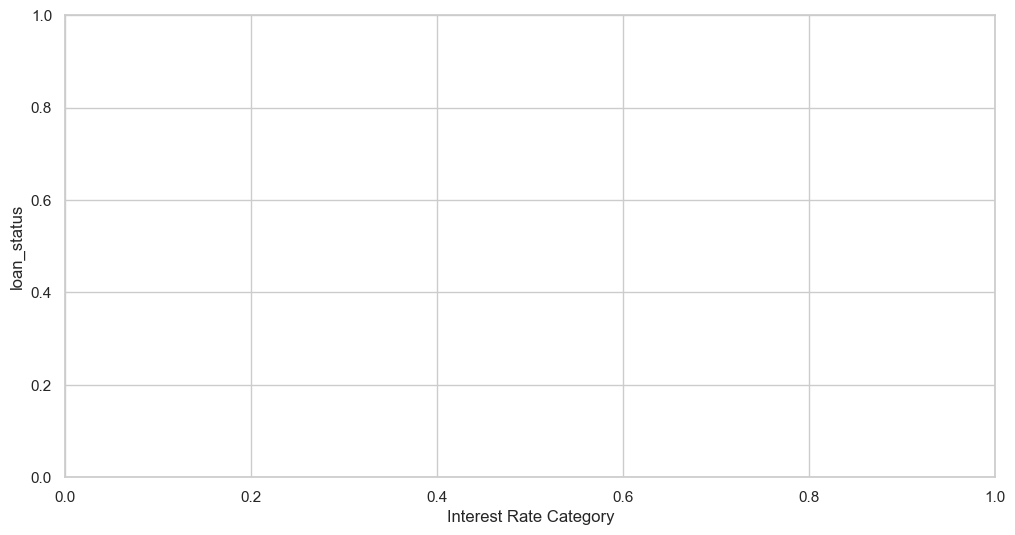

In [85]:
for variable in segment_variables:
    plt.figure(figsize=(12, 6))

    if loan_data[variable].dtype in ['float64', 'int64']:
        sns.boxplot(x='int_rate_category', y=variable, data=loan_data)
        plt.title(f'Distribution of {variable} Across Interest Rate Categories')
    elif variable == 'term':
        sns.countplot(x='int_rate_category', hue=variable, data=loan_data)
        plt.title(f'Count of {variable} Across Interest Rate Categories')

    plt.xlabel('Interest Rate Category')
    plt.ylabel(variable)
    plt.show()

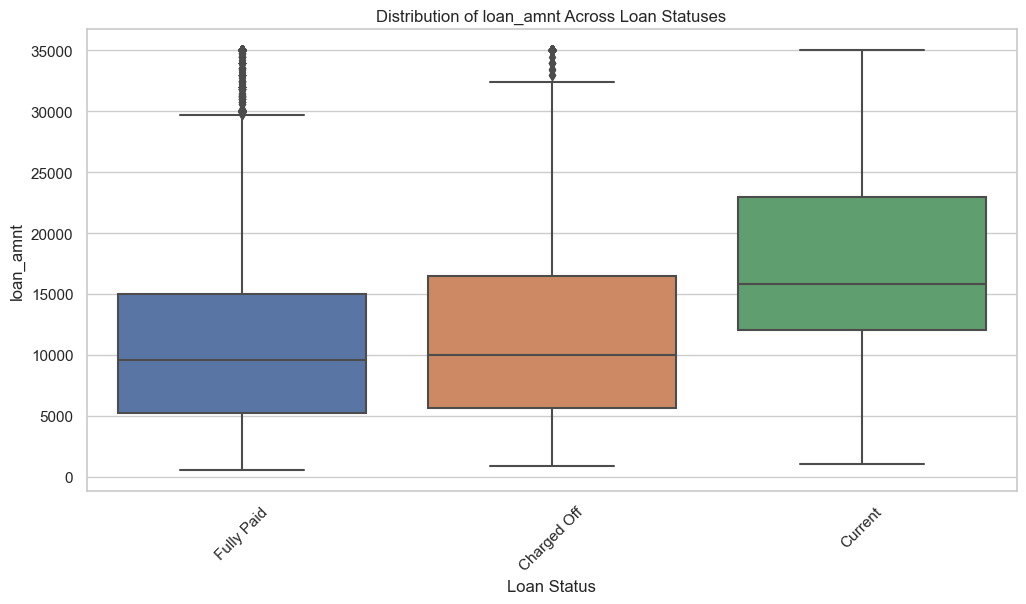

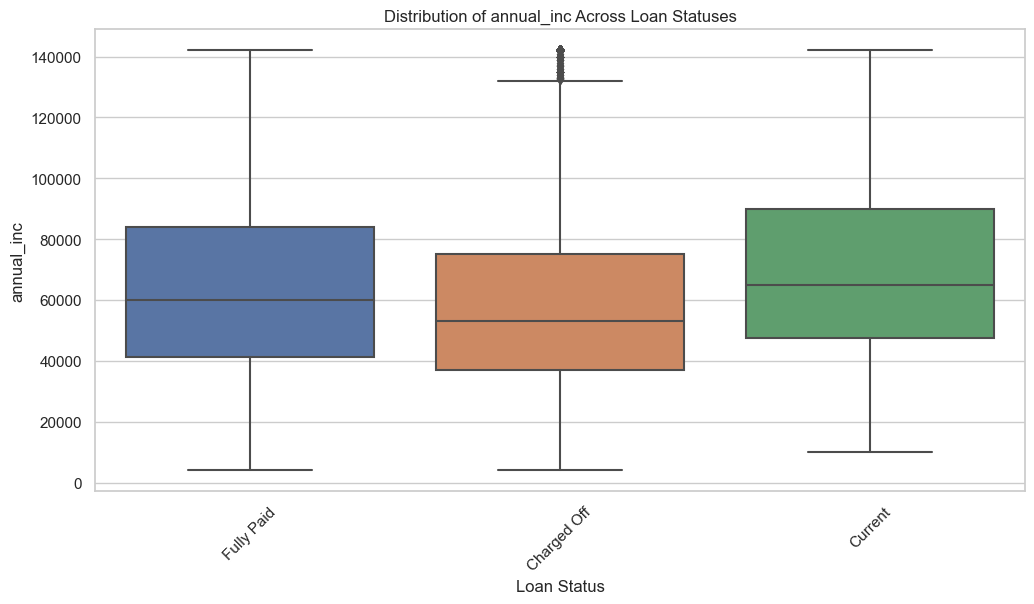

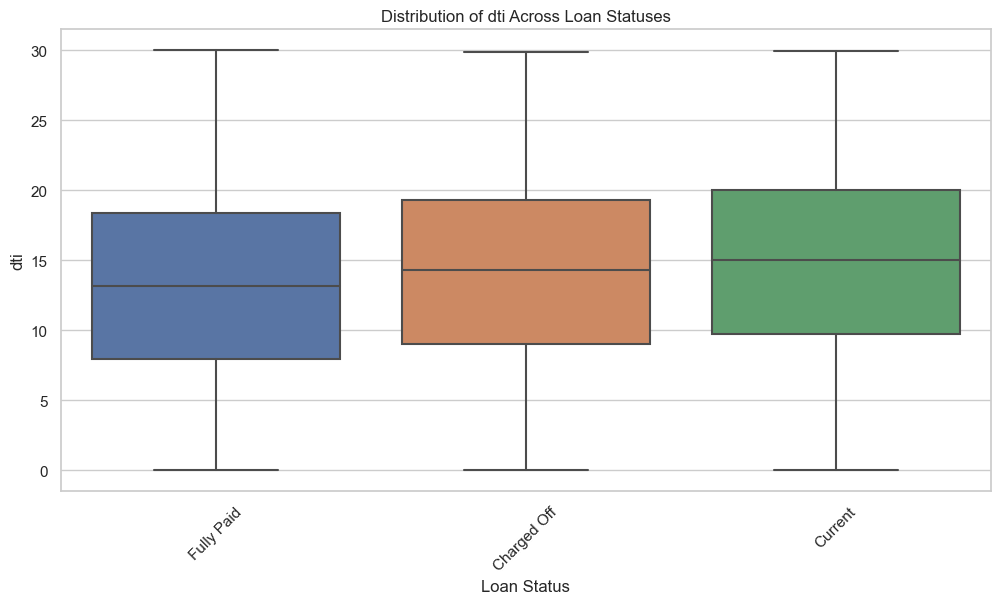

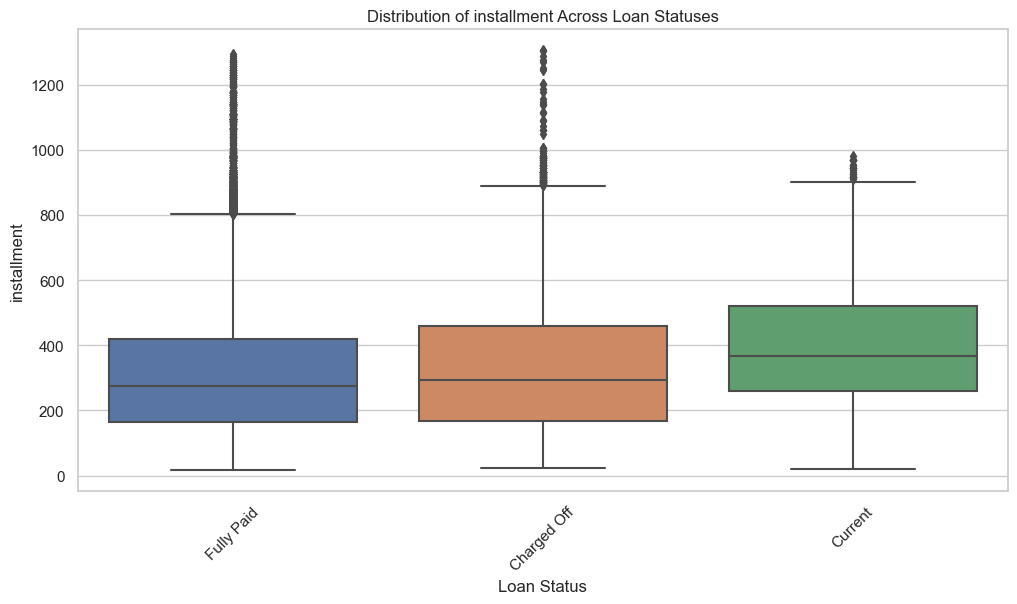

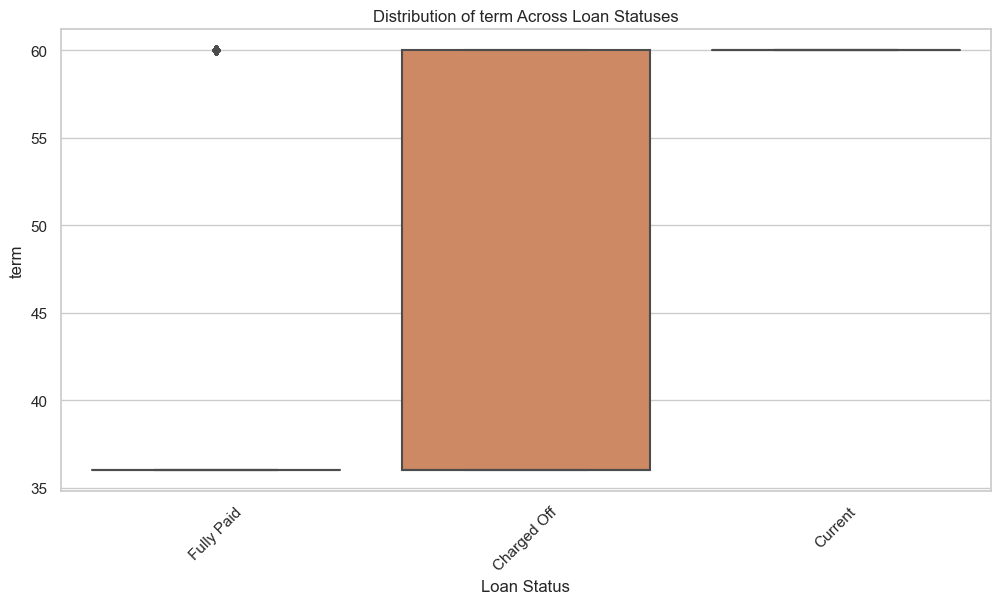

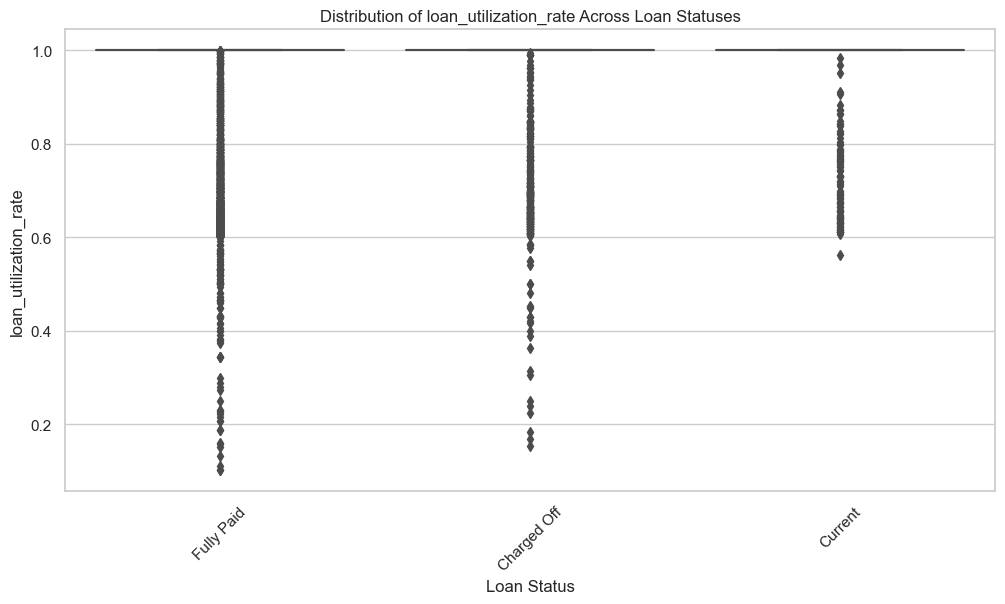

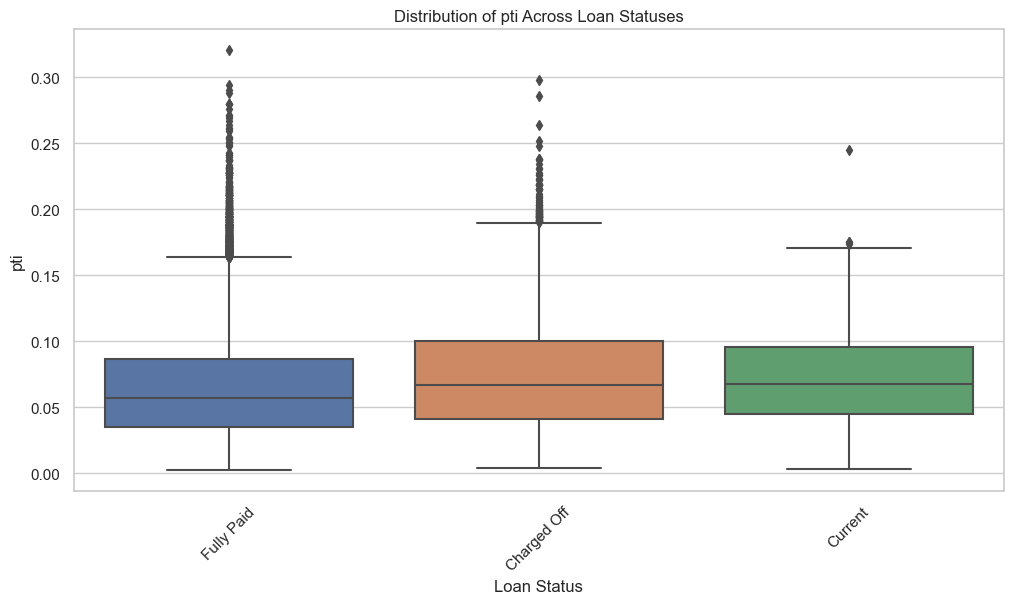

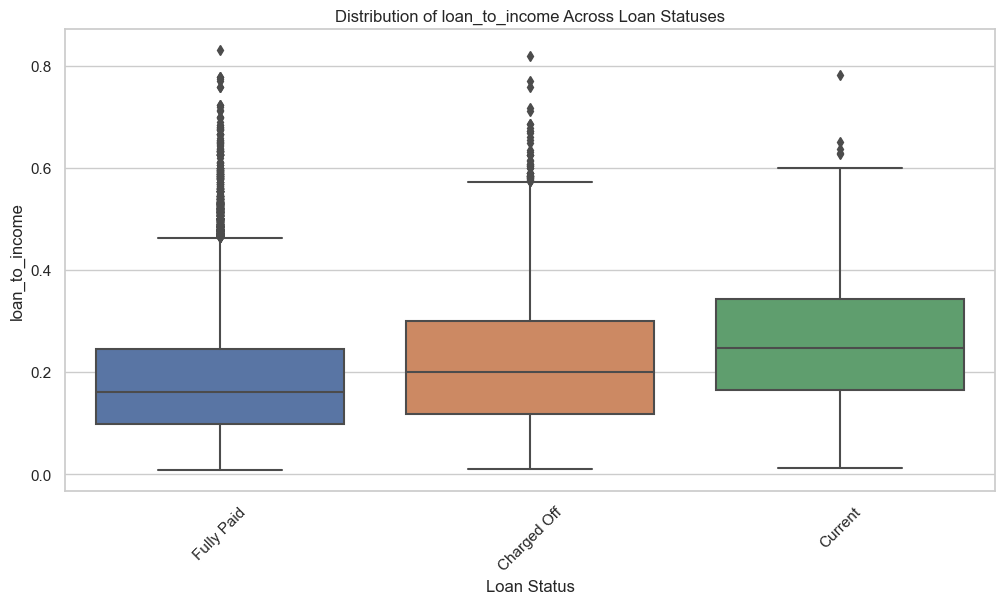

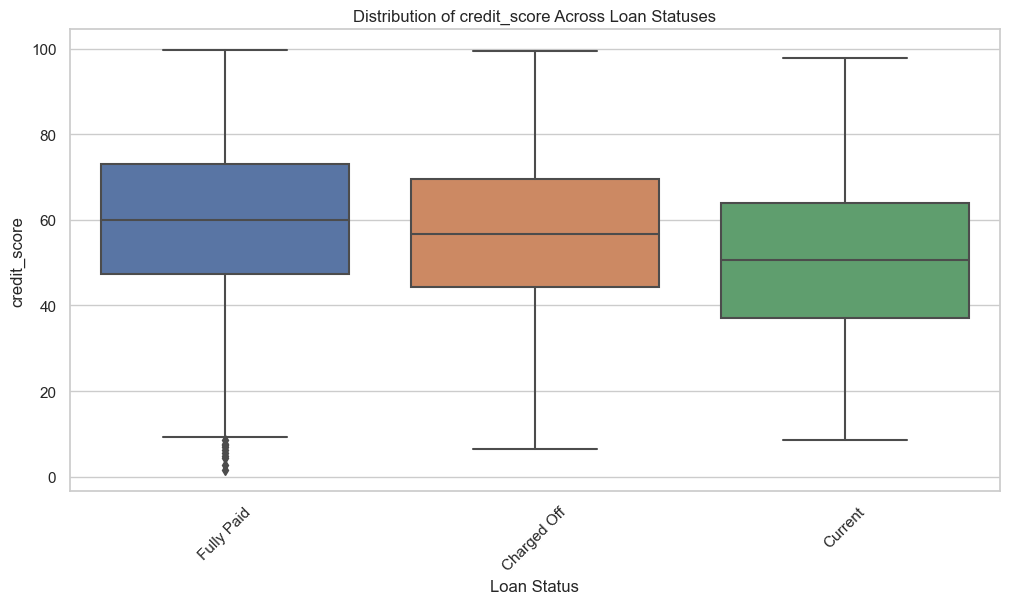

In [86]:
segment_variables3 = ['loan_amnt', 'annual_inc', 'dti', 'installment', 'term', 
                      'loan_utilization_rate', 'pti', 'loan_to_income','credit_score']
for variable in segment_variables3:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='loan_status', y=variable, data=loan_data)
    plt.title(f'Distribution of {variable} Across Loan Statuses')
    plt.xlabel('Loan Status')
    plt.ylabel(variable)
    plt.xticks(rotation=45)
    plt.show()

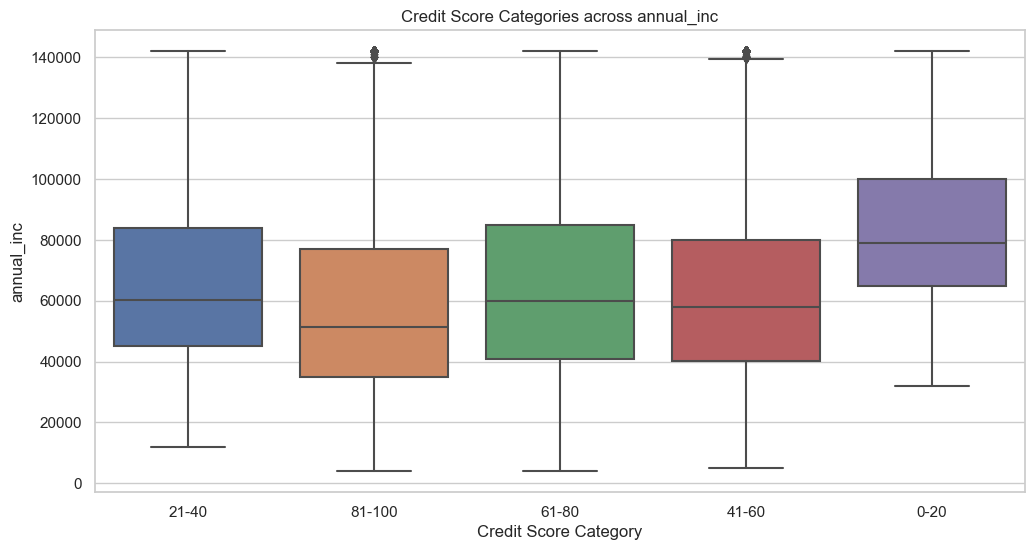

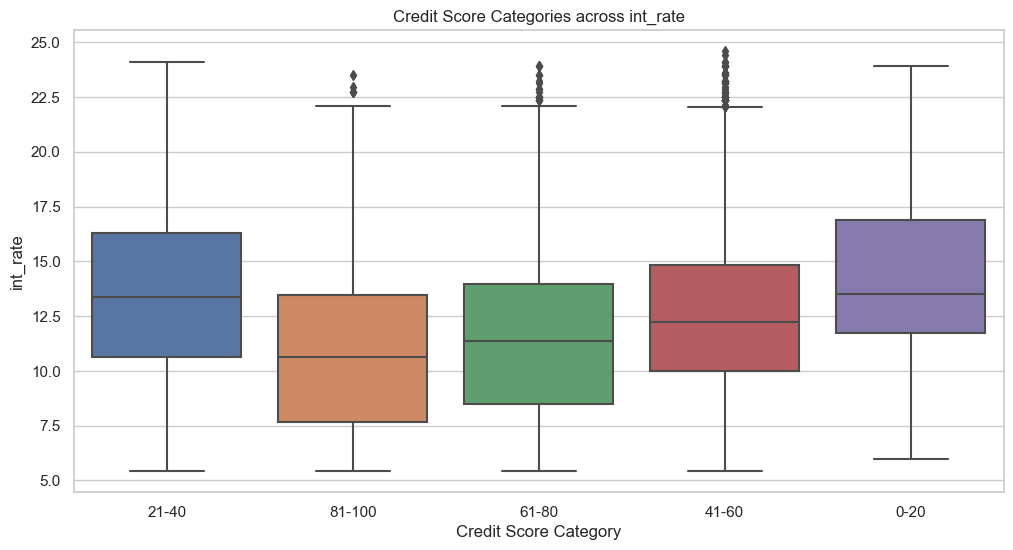

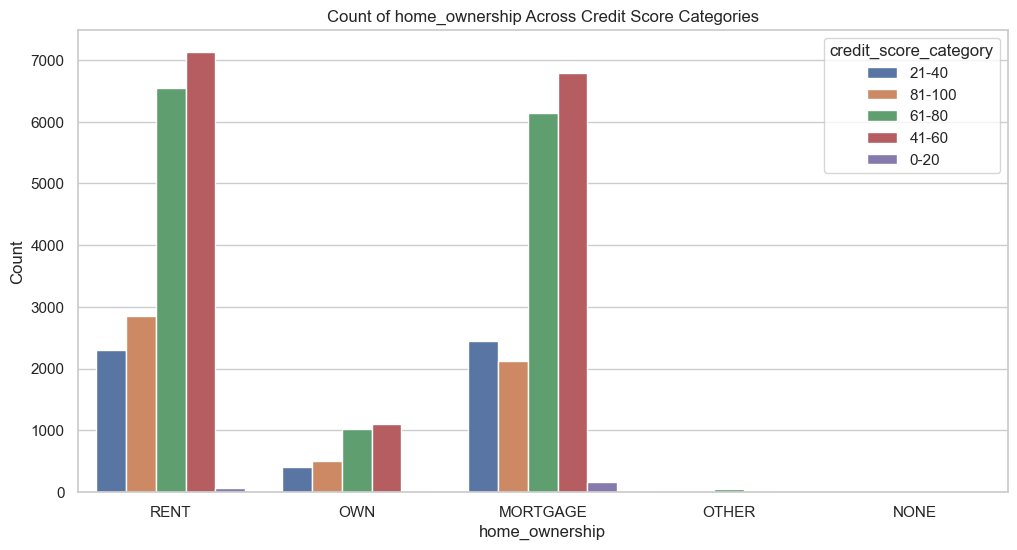

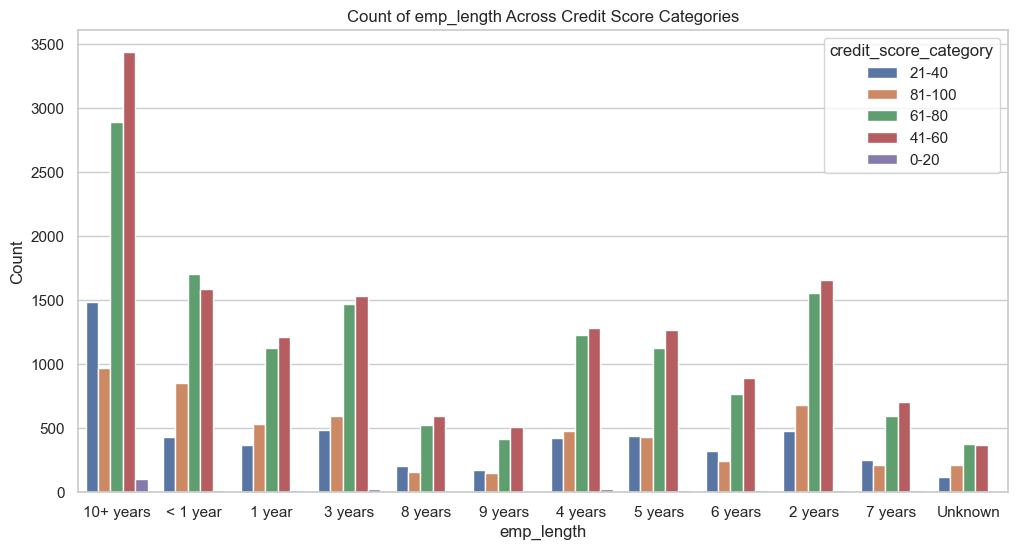

In [87]:
# Adjusted segmented analysis excluding 'emp_title' due to potential high cardinality
segment_variables2 = ['annual_inc', 'int_rate', 'home_ownership', 'emp_length']

for variable in segment_variables2:
    plt.figure(figsize=(12, 6))

    # Use boxplot for numerical variables
    if loan_data[variable].dtype in ['float64', 'int64']:
        sns.boxplot(x='credit_score_category', y=variable, data=loan_data)
        plt.title(f'Credit Score Categories across {variable}')
        plt.xlabel('Credit Score Category')
        plt.ylabel(variable)

    # Use count plot for categorical variables
    elif loan_data[variable].dtype == 'object':
        sns.countplot(x=variable, hue='credit_score_category', data=loan_data)
        plt.title(f'Count of {variable} Across Credit Score Categories')
        plt.xlabel(variable)
        plt.ylabel('Count')

    plt.show()

# bivariate

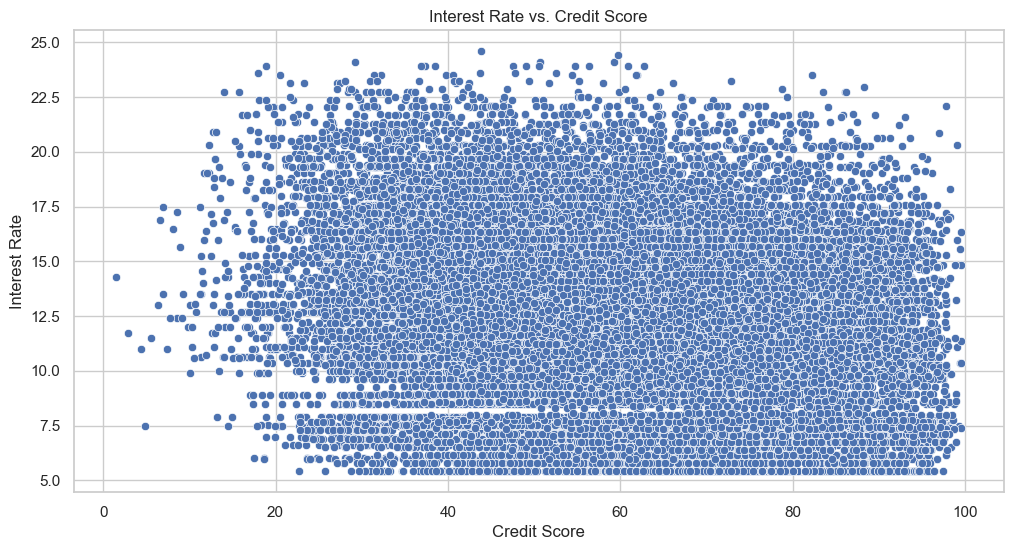

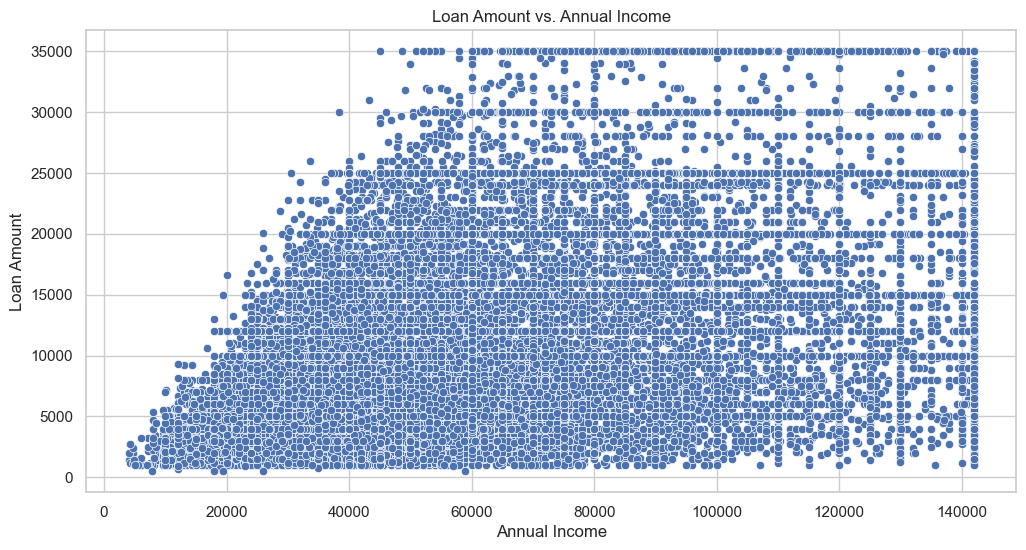

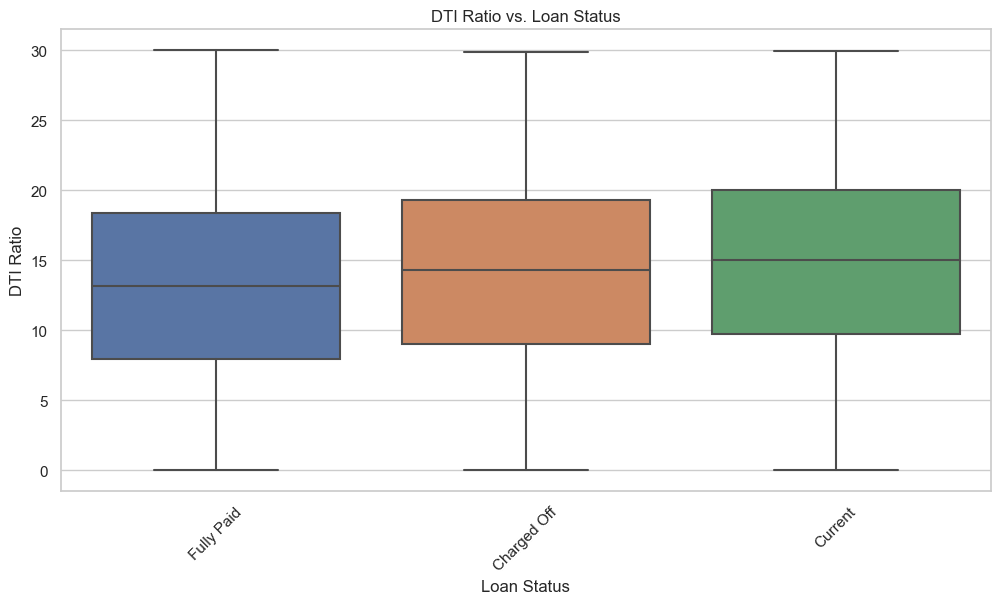

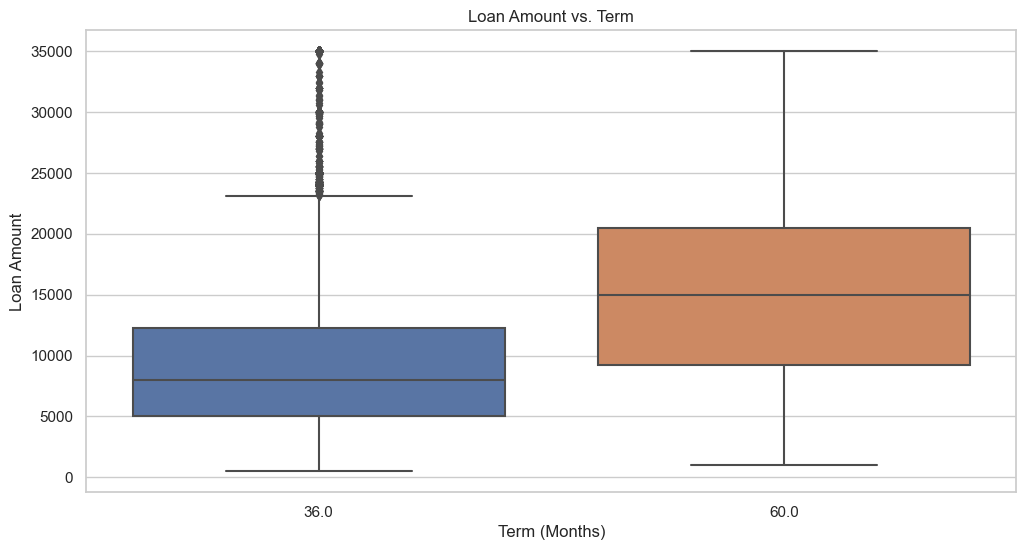

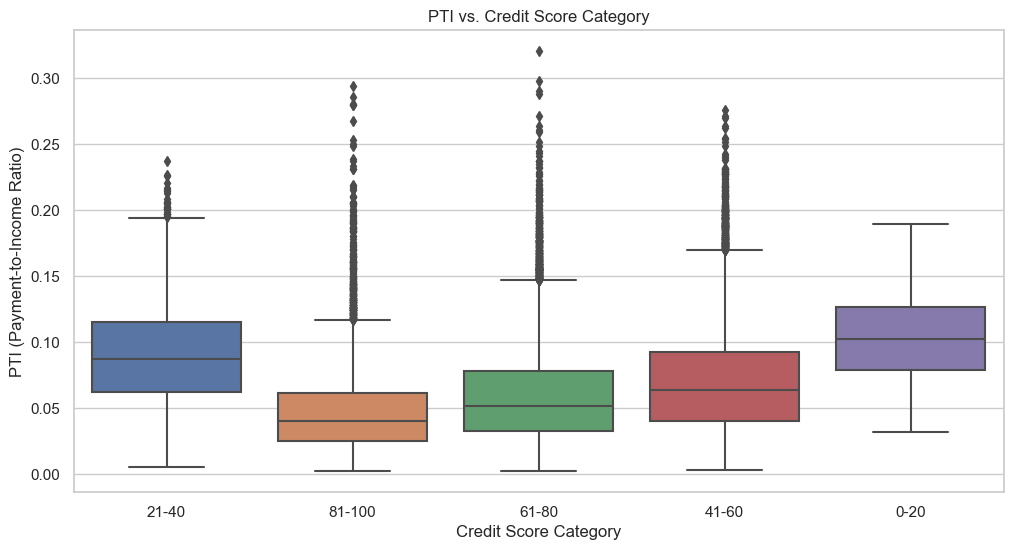

In [88]:
# 1. Interest Rate vs. Credit Score
plt.figure(figsize=(12, 6))
sns.scatterplot(x='credit_score', y='int_rate', data=loan_data)
plt.title('Interest Rate vs. Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Interest Rate')
plt.show()

# 2. Loan Amount vs. Annual Income
plt.figure(figsize=(12, 6))
sns.scatterplot(x='annual_inc', y='loan_amnt', data=loan_data)
plt.title('Loan Amount vs. Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.show()

# 3. DTI Ratio vs. Loan Status
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='dti', data=loan_data)
plt.title('DTI Ratio vs. Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('DTI Ratio')
plt.xticks(rotation=45)
plt.show()

# 4. Loan Amount vs. Term
plt.figure(figsize=(12, 6))
sns.boxplot(x='term', y='loan_amnt', data=loan_data)
plt.title('Loan Amount vs. Term')
plt.xlabel('Term (Months)')
plt.ylabel('Loan Amount')
plt.show()

# Including a derived column: PTI (Payment-to-Income Ratio) vs. Credit Score Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='credit_score_category', y='pti', data=loan_data)
plt.title('PTI vs. Credit Score Category')
plt.xlabel('Credit Score Category')
plt.ylabel('PTI (Payment-to-Income Ratio)')
plt.show()

Pearson Correlation between Annual Income and Loan Amount: 0.44
Spearman Correlation between Annual Income and Loan Amount: 0.43


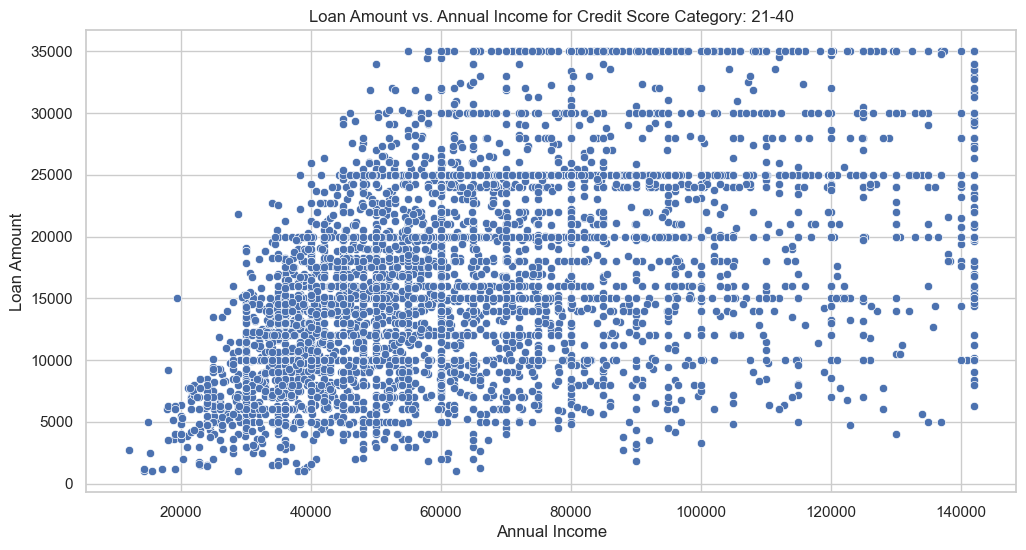

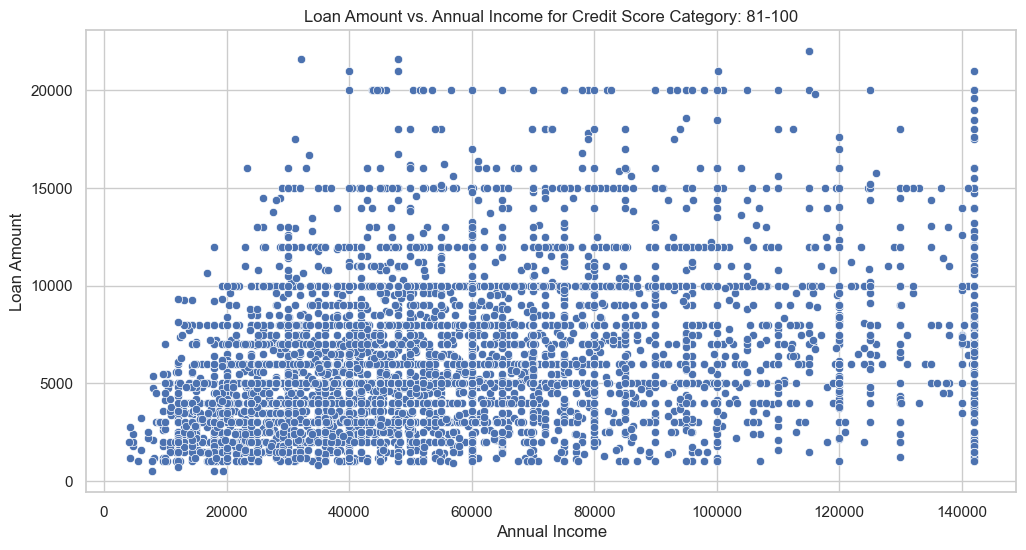

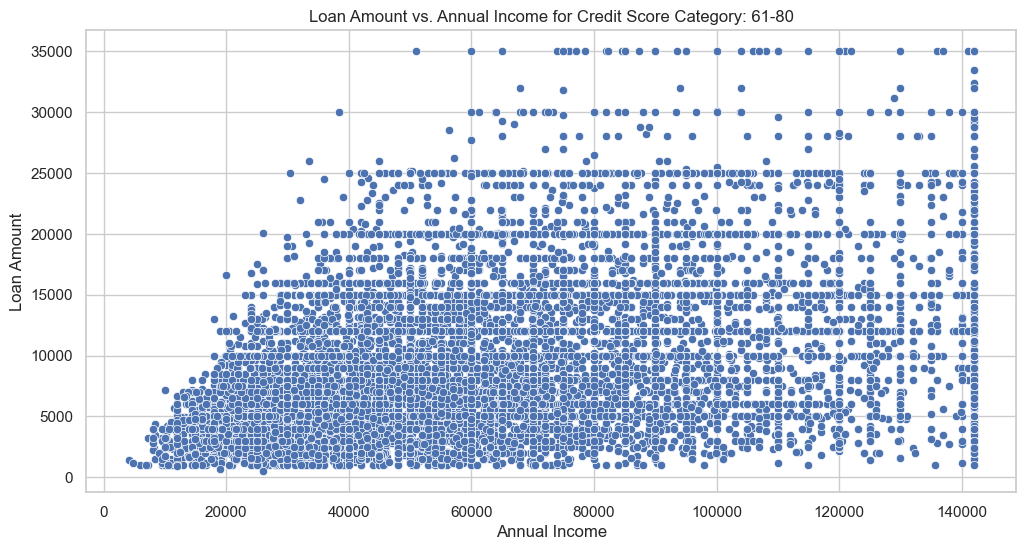

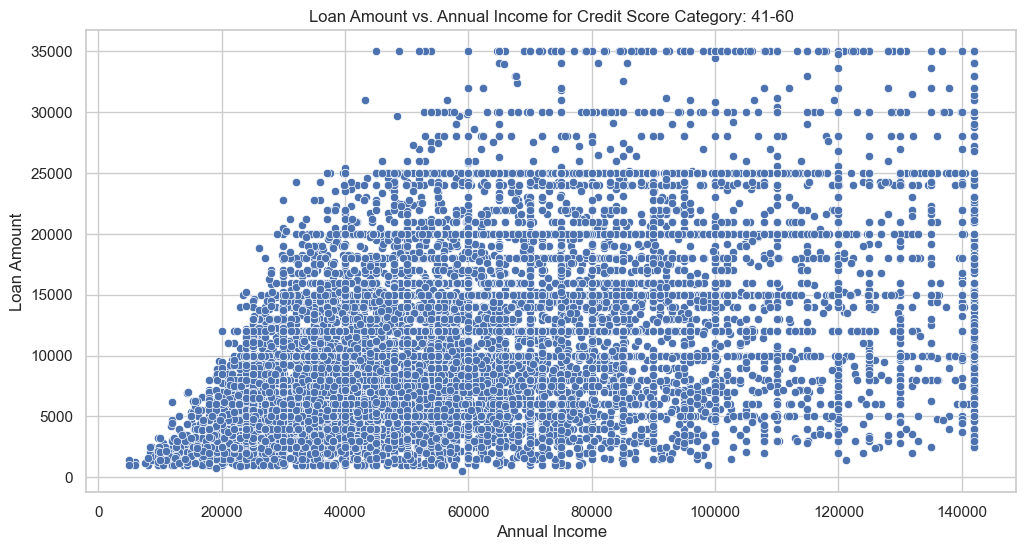

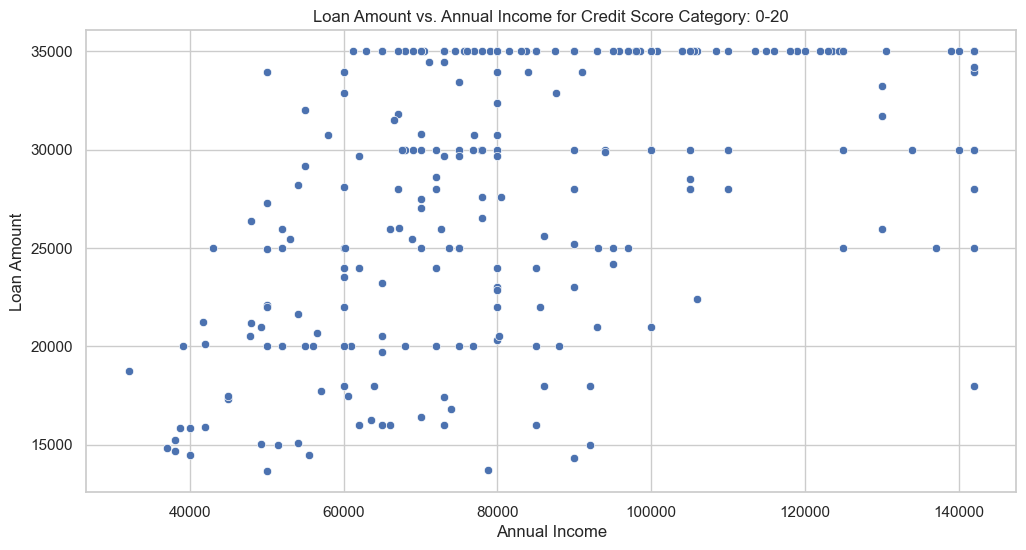

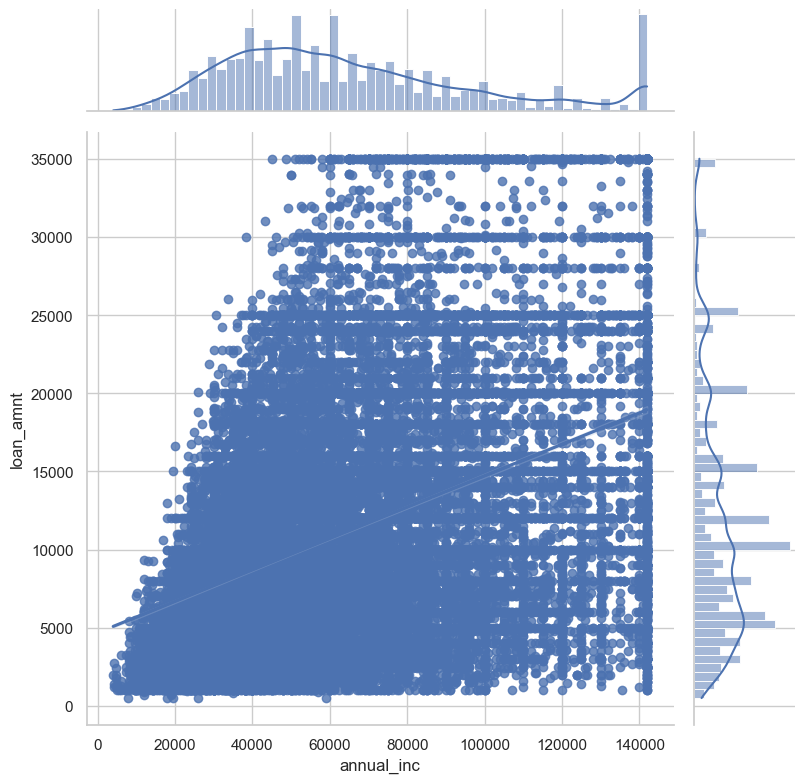

In [89]:
pearson_corr, _ = pearsonr(loan_data['annual_inc'], loan_data['loan_amnt'])
spearman_corr, _ = spearmanr(loan_data['annual_inc'], loan_data['loan_amnt'])
print(f"Pearson Correlation between Annual Income and Loan Amount: {pearson_corr:.2f}")
print(f"Spearman Correlation between Annual Income and Loan Amount: {spearman_corr:.2f}")

# Segmented Bivariate Analysis - Loan Amount vs. Annual Income for different Credit Score Categories
unique_credit_scores = loan_data['credit_score_category'].unique()
for credit_score in unique_credit_scores:
    subset = loan_data[loan_data['credit_score_category'] == credit_score]
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='annual_inc', y='loan_amnt', data=subset)
    plt.title(f'Loan Amount vs. Annual Income for Credit Score Category: {credit_score}')
    plt.xlabel('Annual Income')
    plt.ylabel('Loan Amount')
    plt.show()

# Advanced Visualization - Joint Plot for a Pair of Variables
sns.jointplot(x='annual_inc', y='loan_amnt', data=loan_data, kind='reg', height=8)
plt.show()


/var/folders/0q/clpdbrcs35q427c4ncjr3ttc0000gn/T/ipykernel_62492/1398867966.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = loan_data.corr()


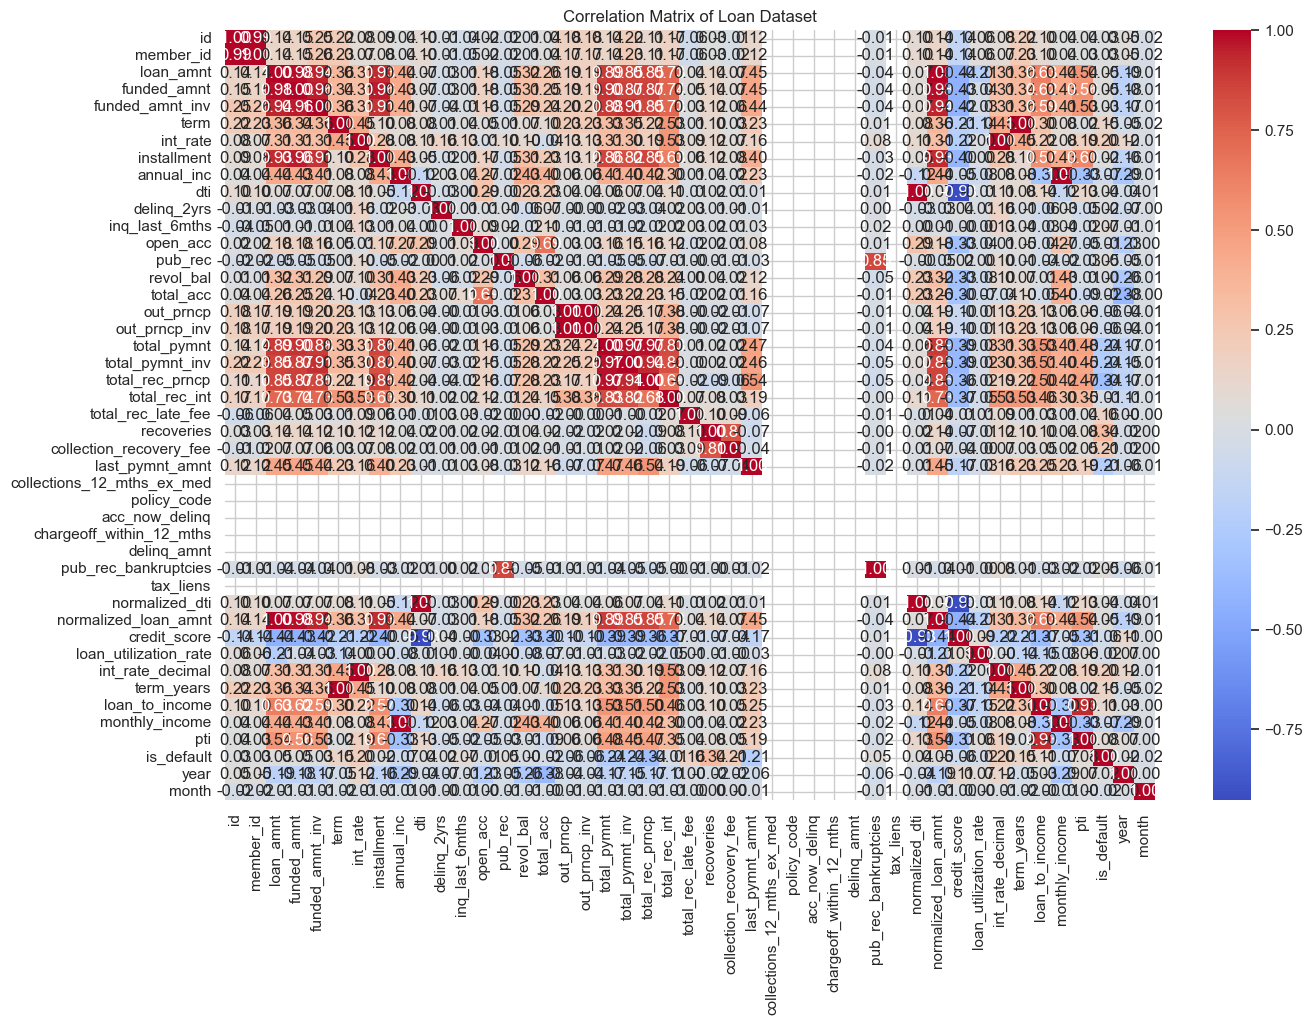

In [90]:
# Creating a correlation matrix for the loan dataset
correlation_matrix = loan_data.corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Loan Dataset')
plt.show()



In [91]:
[loan_data['earliest_cr_line']]

[0       1985-01-01
 1       1999-04-01
 2       2001-11-01
 3       1996-02-01
 4       1996-01-01
            ...    
 39712   1990-11-01
 39713   1986-12-01
 39714   1998-10-01
 39715   1988-11-01
 39716   2003-10-01
 Name: earliest_cr_line, Length: 39717, dtype: datetime64[ns]]

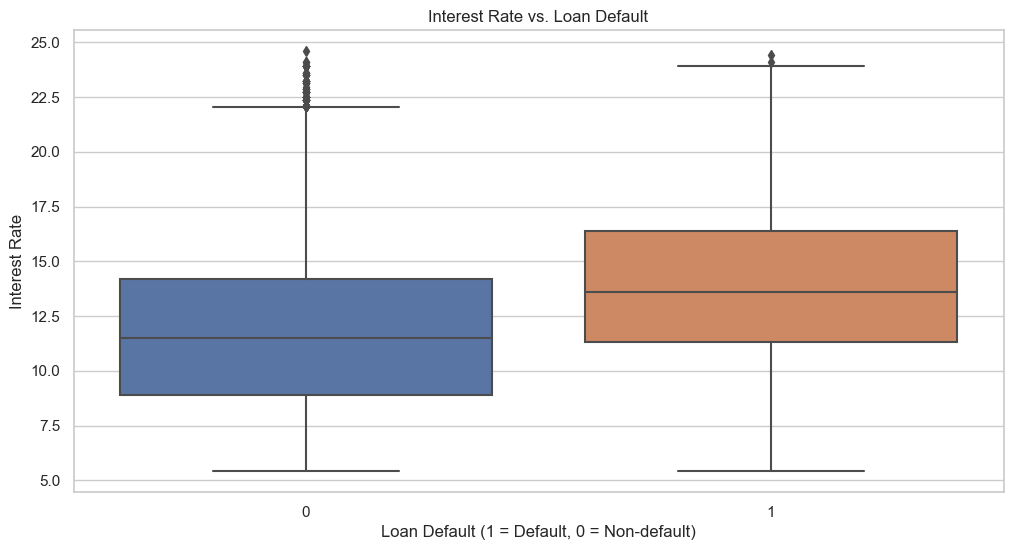

In [92]:


# Plotting the bivariate relationship between Interest Rate and Loan Default
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_default', y='int_rate', data=loan_data)
plt.title('Interest Rate vs. Loan Default')
plt.xlabel('Loan Default (1 = Default, 0 = Non-default)')
plt.ylabel('Interest Rate')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


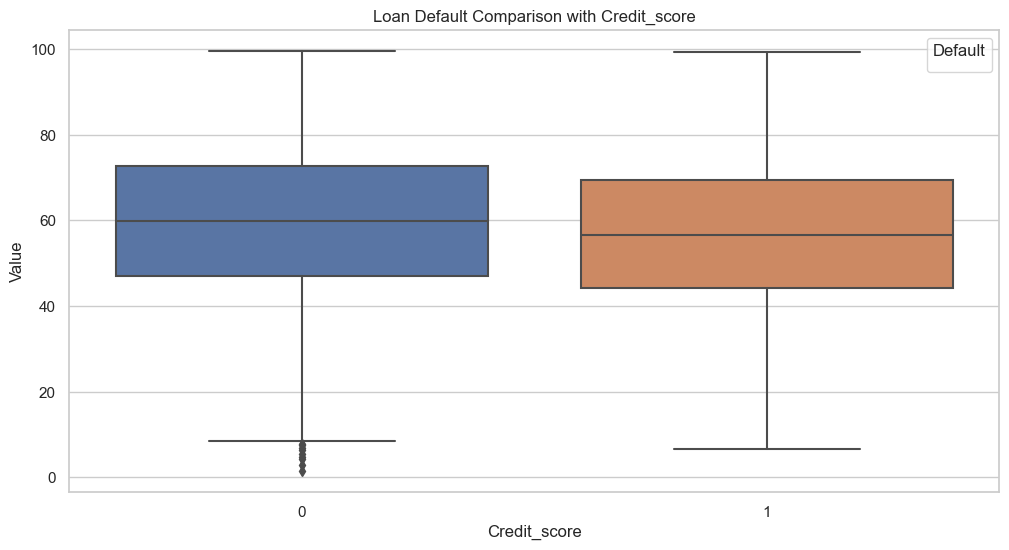

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


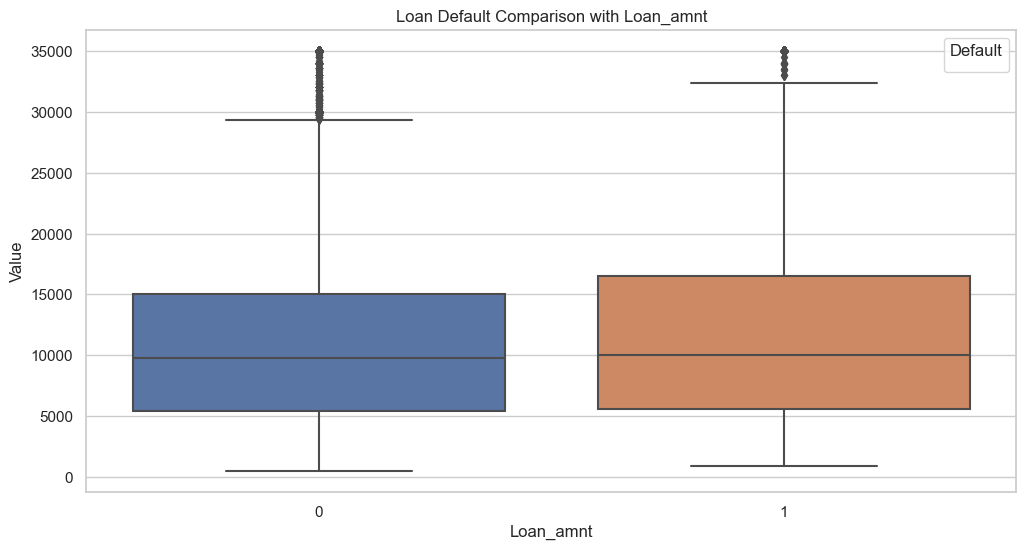

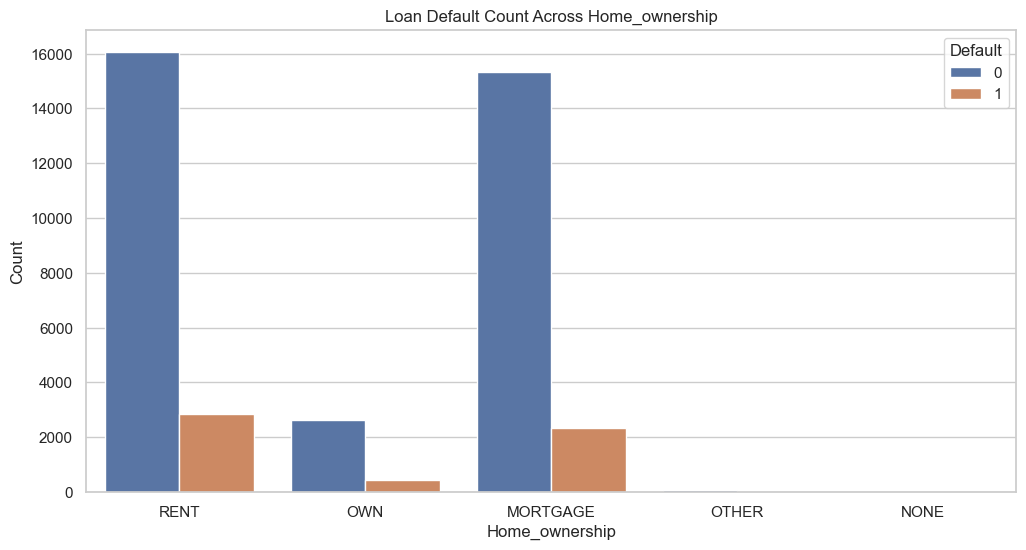

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


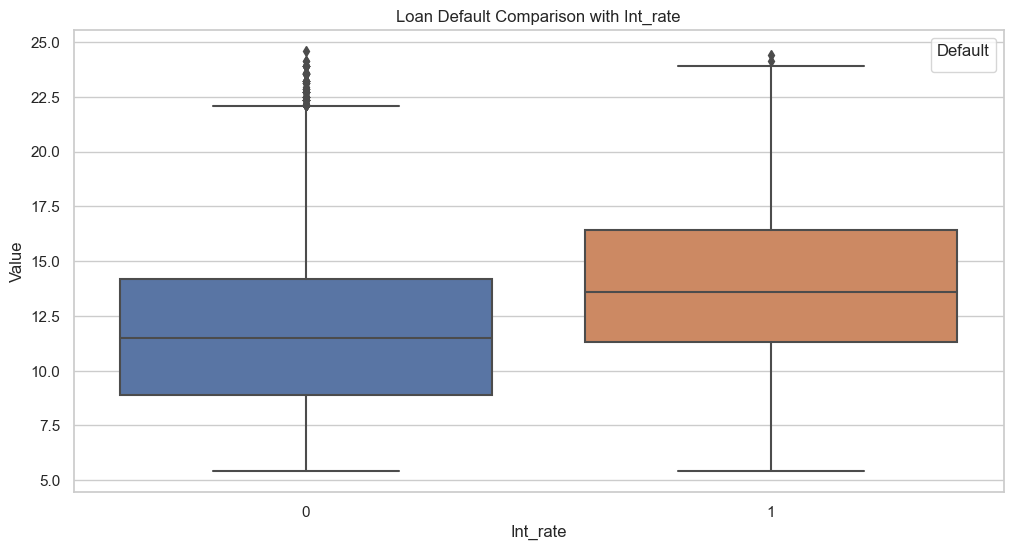

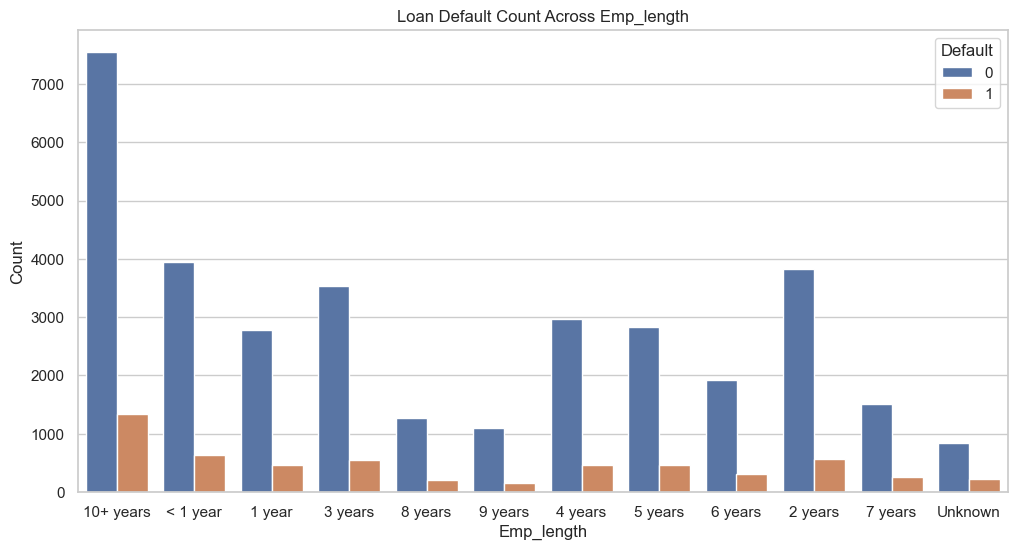

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


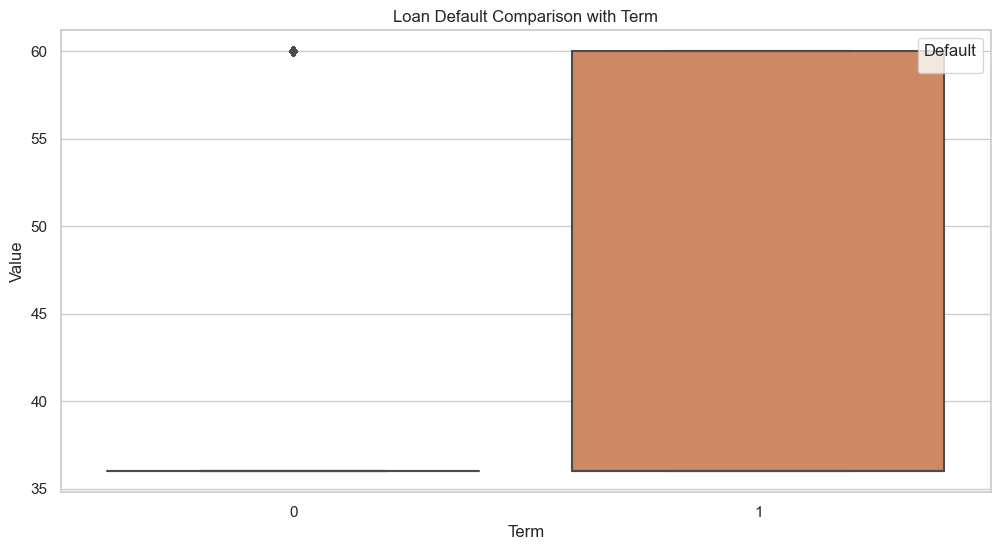

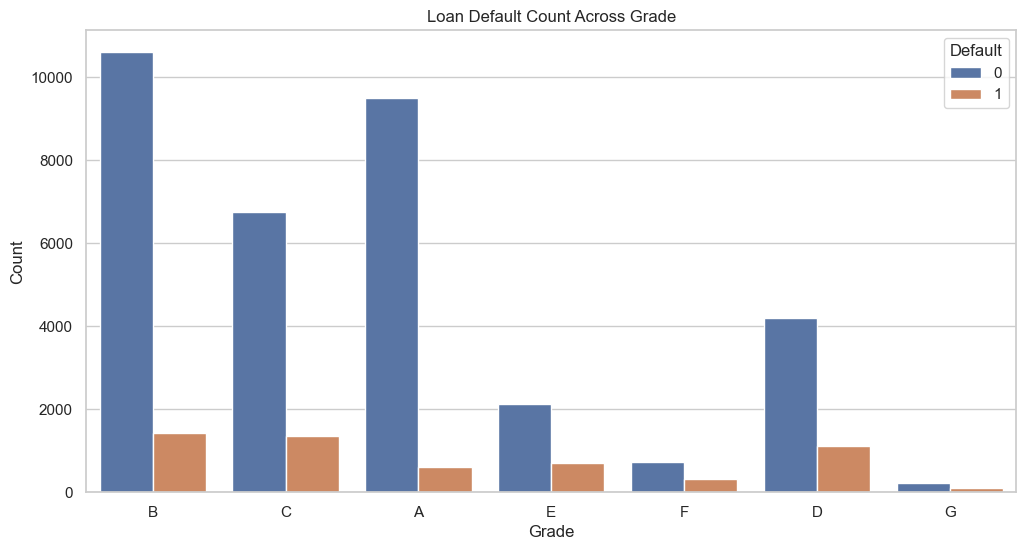

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


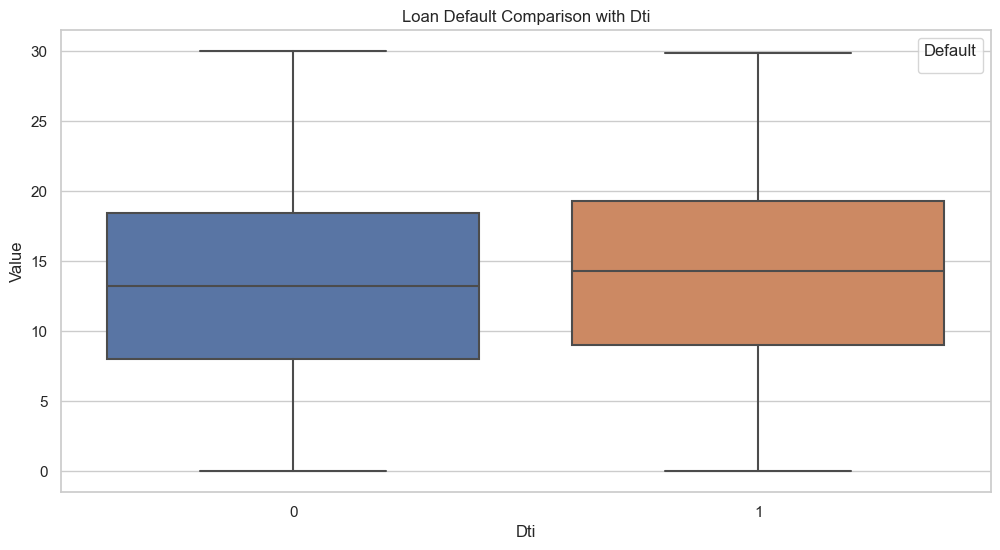

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


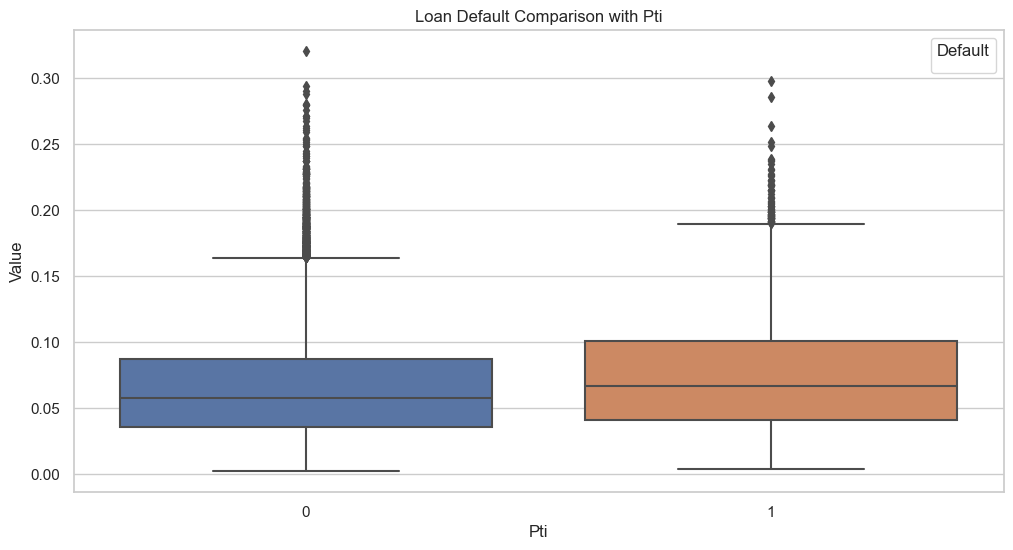

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


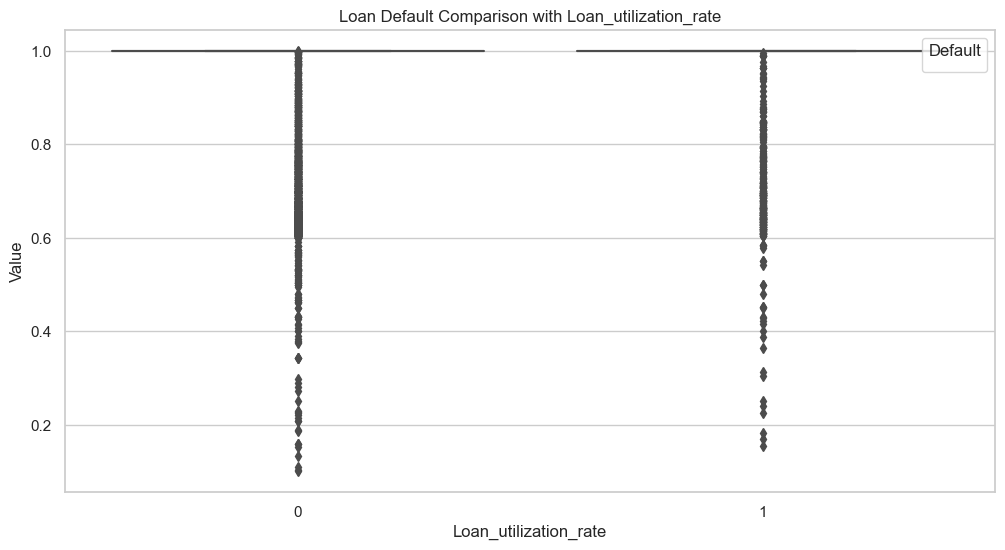

In [96]:
# List of variables for bivariate analysis
compare_variables2 = ['credit_score', 'loan_amnt', 'home_ownership', 'int_rate', 
                     'emp_length', 'term', 'grade', 'dti', 'pti', 'loan_utilization_rate']

# Plotting the bivariate relationships
for variable in compare_variables2:
    plt.figure(figsize=(12, 6))

    # Use countplot for categorical variables
    if loan_data[variable].dtype == 'object' or variable == 'grade':
        sns.countplot(x=variable, hue='is_default', data=loan_data)
        plt.title(f'Loan Default Count Across {variable.capitalize()}')
    # Use boxplot for numerical variables
    else:
        sns.boxplot(x='is_default', y=variable, data=loan_data)
        plt.title(f'Loan Default Comparison with {variable.capitalize()}')
    
    plt.xlabel(variable.capitalize())
    plt.ylabel('Count' if loan_data[variable].dtype == 'object' else 'Value')
    plt.legend(title='Default', loc='upper right')
    plt.show()



In [97]:
# Exclude 'loan_status' from the correlation analysis
columns_for_correlation = [col for col in loan_data.columns if col != 'loan_status']

# Calculate the correlation
correlation_with_default = loan_data[columns_for_correlation].corr()['is_default']
correlation_with_default.drop('is_default', inplace=True)  # Remove the correlation of 'is_default' with itself

correlation_with_default

/var/folders/0q/clpdbrcs35q427c4ncjr3ttc0000gn/T/ipykernel_62492/1592622682.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_default = loan_data[columns_for_correlation].corr()['is_default']


id                            0.028370
member_id                     0.026438
loan_amnt                     0.048217
funded_amnt                   0.045544
funded_amnt_inv               0.026621
term                          0.146038
int_rate                      0.196253
installment                   0.022589
annual_inc                   -0.068794
dti                           0.041701
delinq_2yrs                   0.019904
inq_last_6mths                0.071717
open_acc                     -0.010742
pub_rec                       0.050880
revol_bal                     0.003369
total_acc                    -0.023563
out_prncp                    -0.055476
out_prncp_inv                -0.055417
total_pymnt                  -0.238844
total_pymnt_inv              -0.236232
total_rec_prncp              -0.335019
total_rec_int                -0.010780
total_rec_late_fee            0.163221
recoveries                    0.340297
collection_recovery_fee       0.205394
last_pymnt_amnt          